In [6]:
from torch.utils.data import DataLoader , Dataset
import torch
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchmetrics.classification import BinaryConfusionMatrix # Specifically for binary classification
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

import os
import shutil
from datasets import load_from_disk

from datasets import load_dataset
from datasets import concatenate_datasets, DatasetDict
import time

from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as DEFAULT_STOP_WORDS
import seaborn as sns

In [7]:
from Vanilla_Models import VanillaRNN,VanillaLSTM,VanillaBidirectionalRNN,VanillaBidirectionalLSTM
from attention_classes import   BahdanauAttention, LuongDotProductAttention, LuongGeneralAttention, LuongConcatAttention
from models_with_attention import    VanillaRNNWithPlugAndPlayAttention,VanillaBidirectionalRNNWithPlugAndPlayAttention,VanillaLSTMWithPlugAndPlayAttention,VanillaBidirectionalLSTMWithPlugAndPlayAttention

ModuleNotFoundError: No module named 'Vanilla_Models'

In [ ]:
# Ensure SpaCy is loaded
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

if torch.cuda.is_available():
        # Get the name of the first GPU (device 0)
        gpu_name = torch.cuda.get_device_name(0)
        print(f"GPU Name (Device 0): {gpu_name}")

if torch.cuda.is_available():
        # Get memory statistics for the first GPU (device 0)
        memory_stats = torch.cuda.memory_stats(0)
        print(f"GPU Memory Stats (Device 0): {memory_stats}")

        # You can also get specific memory details like allocated bytes
        allocated_bytes = torch.cuda.memory_allocated(0)
        print(f"Allocated memory (Device 0): {allocated_bytes / (1024**3):.2f} GB")


Number of GPUs: 1
GPU Name (Device 0): NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory Stats (Device 0): OrderedDict({'active.all.allocated': 0, 'active.all.current': 0, 'active.all.freed': 0, 'active.all.peak': 0, 'active.large_pool.allocated': 0, 'active.large_pool.current': 0, 'active.large_pool.freed': 0, 'active.large_pool.peak': 0, 'active.small_pool.allocated': 0, 'active.small_pool.current': 0, 'active.small_pool.freed': 0, 'active.small_pool.peak': 0, 'active_bytes.all.allocated': 0, 'active_bytes.all.current': 0, 'active_bytes.all.freed': 0, 'active_bytes.all.peak': 0, 'active_bytes.large_pool.allocated': 0, 'active_bytes.large_pool.current': 0, 'active_bytes.large_pool.freed': 0, 'active_bytes.large_pool.peak': 0, 'active_bytes.small_pool.allocated': 0, 'active_bytes.small_pool.current': 0, 'active_bytes.small_pool.freed': 0, 'active_bytes.small_pool.peak': 0, 'allocated_bytes.all.allocated': 0, 'allocated_bytes.all.current': 0, 'allocated_bytes.all.freed': 0, 'allocated_bytes

In [ ]:
# import os

# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
x = torch.tensor([1.0]).cuda()
print(x)

tensor([1.], device='cuda:0')


In [ ]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

12.6
True


In [ ]:

NEGATION_WORDS_TO_KEEP = {
    "not", "no", "never", "none", "nothing", "nowhere", "hardly", "scarcely", "barely",
    "don't", "doesn't", "didn't", "isn't", "aren't", "wasn't", "weren't",
    "won't", "wouldn't", "can't", "couldn't", "shouldn't", "mightn't", "mustn't"
}

CUSTOM_STOP_WORDS = DEFAULT_STOP_WORDS - NEGATION_WORDS_TO_KEEP

In [ ]:
def custom_tokenize_and_filter(text_input, nlp_model, stop_words_set, include_emoticons=True):
    doc = nlp_model(text_input)
    processed_tokens = []
    for token in doc:
        token_text_lower = token.text.lower()
        
        # Rule 1: Filter out standalone punctuation and spaces
        if token.is_punct or token.is_space:
            # Rule 1a: Optional - keep specific emoticons even if they are punctuation
            if include_emoticons and token_text_lower in [":-)", ":)", ":(", ";)", ":P", ":O", ":|"]:
                processed_tokens.append(token_text_lower)
            continue # Skip other punctuation and spaces

        # Rule 2: Filter out stop words (but only if NOT in our kept negation list)
        if token_text_lower in stop_words_set:
            continue # Skip stop words

        # Rule 3: Keep numbers as is (or replace with [NUM] if preferred)
        # For sentiment, keeping them is often fine, unless they are just noise.
        if token.like_num:
           processed_tokens.append("<NUM>")
  
        else:
         processed_tokens.append(token_text_lower)
            
    return processed_tokens

In [ ]:
GLOVE_PATH = './Important_Sub_Outputs/glove.6B.100d.txt' # Make sure this file is in the same directory or provide full path
GLOVE_EMBEDDING_DIM = 100 # Match the dimension of your downloaded GloVe file

glove_embeddings = {}
try:
    with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    print(f"Loaded {len(glove_embeddings)} words from GloVe.")
except FileNotFoundError:
    print(f"Error: GloVe file not found at {GLOVE_PATH}. Please download it from https://nlp.stanford.edu/projects/glove/.")
    print("For example, download glove.6B.zip and extract glove.6B.100d.txt.")



Loaded 400000 words from GloVe.


In [ ]:
import json
word_to_idx_path = "./Important_Sub_Outputs/word_to_idx.json"

with open(word_to_idx_path, 'r') as f:
    word_to_idx = json.load(f)
print(f"Loaded word_to_idx. Sample: {list(word_to_idx.items())[:5]}...")

MAX_LEN = 1337
VOCAB_SIZE = len(word_to_idx)

Loaded word_to_idx. Sample: [('<PAD>', 0), ('<UNK>', 1), ('/><br', 2), ('movie', 3), ('film', 4)]...


In [ ]:
# --- Step 3: Create the Embedding Matrix for Your Model ---

# Define special tokens
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'






embedding_matrix = np.random.uniform(-0.25, 0.25, (VOCAB_SIZE, GLOVE_EMBEDDING_DIM))

# Fill the matrix with GloVe vectors where available
for word, idx in word_to_idx.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        # Handle Out-Of-Vocabulary (OOV) words from your dataset that are not in GloVe
        # For UNK_TOKEN, it will be randomly initialized, which is fine.
        # For PAD_TOKEN, it remains randomly initialized, or you could explicitly set it to zeros.
        if word == PAD_TOKEN:
            embedding_matrix[idx] = np.zeros(GLOVE_EMBEDDING_DIM) # Set PAD to zeros
        # Other OOV words in your vocab will remain randomly initialized.

# Convert to a PyTorch tensor
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

print(f"\nShape of the final embedding matrix for your model: {embedding_matrix_tensor.shape}")


Shape of the final embedding matrix for your model: torch.Size([128465, 100])


In [ ]:
def evaluate_model_on_review(sample_review, model,return_attention_weights = False):
    """
    Evaluates the sentiment of a given review using the provided model and tokenizer.
    
    Args:
        sample_review (str): The review text to evaluate.
        model: The trained sentiment analysis model.
        nlp: The spaCy NLP object for tokenization.
        word_to_idx (dict): Mapping from words to their indices.
        CUSTOM_STOP_WORDS (set): Set of custom stop words to filter out.
        MAX_LEN (int): Maximum length for padding/truncation.
        PAD_TOKEN (str): Token used for padding.
        device (str): Device to run the model on ('cpu' or 'cuda').
    
    Returns:
        None: Prints the sentiment prediction.
    """


    
    tokens_processed = custom_tokenize_and_filter(sample_review, nlp, CUSTOM_STOP_WORDS, include_emoticons=True)


    tokens_processed_indices = [word_to_idx[token] for token in tokens_processed ]
    tokens_processed_indices
    if len(tokens_processed_indices) < MAX_LEN:
        padded_ids = tokens_processed_indices + [word_to_idx[PAD_TOKEN]] * (MAX_LEN - len(tokens_processed_indices))
        mask = [1] * len(tokens_processed_indices) + [0] * (MAX_LEN - len(tokens_processed_indices))
    elif len(tokens_processed_indices) > MAX_LEN:
        padded_ids = tokens_processed_indices[:MAX_LEN]
        mask = [1] * MAX_LEN
    else: # Exactly MAX_LEN
        padded_ids = tokens_processed_indices
        mask = [1] * MAX_LEN
    if return_attention_weights== False:
        output = F.sigmoid(model.forward(torch.tensor(padded_ids,device = device).unsqueeze(0),torch.tensor(mask,device = device).unsqueeze(0)))
    else:
        output,attention_weights = model.forward(torch.tensor(padded_ids,device = device).unsqueeze(0),torch.tensor(mask,device = device).unsqueeze(0))
        output = F.sigmoid(output)
    output = output.item()
    result = "Positive" if output > 0.5 else "Negative"
    print(f"Model : {model.__class__.__name__ } Sentiment: {result} (Score: {output:.4f})")

    if return_attention_weights:
        return output, attention_weights,mask
    else:
        return output

In [ ]:



## Visualization of model's performance
model_names = [
    "VanillaBidirectionalLSTM",
  "VanillaBidirectionalRNNWithBahdanauAttention",
    "VanillaBidirectionalLSTMWithLuongConcatAttention",
    "VanillaBidirectionalLSTMWithLuongDotProductAttention",
    "VanillaBidirectionalLSTMWithLuongGeneralAttention",
    "VanillaBidirectionalRNN",
    "VanillaBidirectionalRNNWithBahdanauAttention",
    "VanillaBidirectionalRNNWithLuongConcatAttention",
    "VanillaBidirectionalRNNWithLuongDotProductAttention",
    "VanillaBidirectionalRNNWithLuongGeneralAttention",
    "VanillaLSTM",
    "VanillaLSTMWithBahdanauAttention",
    "VanillaLSTMWithLuongConcatAttention",
    "VanillaLSTMWithLuongDotProductAttention",
    "VanillaLSTMWithLuongGeneralAttention",
    "VanillaRNN",
    "VanillaRNNWithBahdanauAttention",
    "VanillaRNNWithLuongConcatAttention",
    "VanillaRNNWithLuongDotProductAttention",
    "VanillaRNNWithLuongGeneralAttention"
]

vanilla_rnn_names = [name for name in model_names if name.startswith("VanillaRNN") and "Bidirectional" not in name]
vanilla_birnn_names = [name for name in model_names if name.startswith("VanillaBidirectionalRNN")]
vanilla_lstm_names = [name for name in model_names if name.startswith("VanillaLSTM") and "Bidirectional" not in name]
vanilla_bilstm_names = [name for name in model_names if name.startswith("VanillaBidirectionalLSTM")]
vanilla_models = [VanillaRNN, VanillaBidirectionalRNN, VanillaLSTM, VanillaBidirectionalLSTM]


In [ ]:
vanilla_birnn_names

['VanillaBidirectionalRNNWithBahdanauAttention',
 'VanillaBidirectionalRNN',
 'VanillaBidirectionalRNNWithBahdanauAttention',
 'VanillaBidirectionalRNNWithLuongConcatAttention',
 'VanillaBidirectionalRNNWithLuongDotProductAttention',
 'VanillaBidirectionalRNNWithLuongGeneralAttention']

Unfortunately "The movie was not so good but I liked it " vs "The movie was not so good but I liked it  very very much" has no effect cause very is removed.....

**I guess the best way would be to learn stop words from data itself**

In [ ]:

sample_review = "The movie was not bad  and  I liked   it "

for model_class in vanilla_models:
    model_path = f"./saved_models/{model_class.__name__}/best_model.pth"
    state_dict = torch.load(model_path)

    model = model_class(embedding_matrix_tensor)
    model.load_state_dict(state_dict)
    model = model.to(device)
    evaluate_model_on_review(sample_review, model)



Model : VanillaRNN Sentiment: Negative (Score: 0.4334)
Model : VanillaBidirectionalRNN Sentiment: Positive (Score: 0.5475)
Model : VanillaLSTM Sentiment: Positive (Score: 0.7270)
Model : VanillaBidirectionalLSTM Sentiment: Positive (Score: 0.5042)


In [ ]:
HIDDEN_DIM = 128

attention_kwargs = [
    {"attention_hidden_dim": HIDDEN_DIM}, # Bahdanau
    {},                                   # LuongDotProduct
    {},                                   # LuongGeneral
    {"attention_hidden_dim": HIDDEN_DIM}  # LuongConcat
]
plug_and_play_attention_models = [
   VanillaRNNWithPlugAndPlayAttention,
   VanillaBidirectionalRNNWithPlugAndPlayAttention,
    VanillaLSTMWithPlugAndPlayAttention,
    VanillaBidirectionalLSTMWithPlugAndPlayAttention,
]
attention_types = [BahdanauAttention, LuongDotProductAttention, LuongGeneralAttention, LuongConcatAttention]


for pap_a_model in plug_and_play_attention_models:
    for attention_type, attention_kwarg in zip(attention_types, attention_kwargs):
        base_model_name = pap_a_model.__name__.replace("WithPlugAndPlayAttention", "")
        attn_name = attention_type.__name__.replace("Attention", "")
        full_model_name = f"{base_model_name}With{attn_name}Attention"
        
        print(f"\n--- Training {full_model_name} ---")

        model_path = f"./saved_models/{full_model_name}/best_model.pth"
        state_dict = torch.load(model_path)

        model = pap_a_model(
            embedding_matrix=embedding_matrix_tensor,
            attention_class=attention_type,
            attention_kwargs=attention_kwarg,
            hidden_dim=HIDDEN_DIM,
            freeze_embeddings=True
        ).to(device)


        model.load_state_dict(state_dict)
        evaluate_model_on_review(sample_review, model)




--- Training VanillaRNNWithBahdanauAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)

--- Training VanillaRNNWithLuongDotProductAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.4446)

--- Training VanillaRNNWithLuongGeneralAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3716)

--- Training VanillaRNNWithLuongConcatAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0001)

--- Training VanillaBidirectionalRNNWithBahdanauAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.7105)

--- Training VanillaBidirectionalRNNWithLuongDotProductAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.4840)

--- Training VanillaBidirectionalRNNWithLuongGeneralAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.

# Visualization of Attention Weights

# Let's analyze with our best model

In [ ]:
def visualize_attention_for_review(
    sample_review,
    model_class,
    attention_class,
    attention_kwargs,
    model_path,
    evaluate_model_on_review_func=None
):
    """
    Loads a model, predicts sentiment and visualizes attention weights for a given review.
    """
    model = model_class(
        embedding_matrix=embedding_matrix_tensor,
        attention_class=attention_class,
        attention_kwargs=attention_kwargs,
        hidden_dim=HIDDEN_DIM,
        freeze_embeddings=True,
        return_attention_weights=True
    )
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.to(device)
    if evaluate_model_on_review_func is None:
        evaluate_model_on_review_func = evaluate_model_on_review
    output, attention_weights, mask = evaluate_model_on_review_func(sample_review, model, True)
    real_length_of_sentence = sum(mask)
    attention_weights_trimmed = attention_weights[:, :real_length_of_sentence]
    tokens_processed = custom_tokenize_and_filter(sample_review, nlp, CUSTOM_STOP_WORDS, include_emoticons=True)
    sentiment = "Positive" if output > 0.5 else "Negative"
    plt.figure(figsize=(len(tokens_processed), 2))
    ax = sns.heatmap(
        attention_weights_trimmed.cpu().detach().numpy(),
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        xticklabels=tokens_processed,
        yticklabels=["Attention"]
    )
    plt.xlabel("Tokens")
    plt.title(f"Sentiment: {sentiment} (Score: {output:.4f})", fontsize=14)
    plt.show()
    fig = ax.get_figure() # Get the Figure object from the Axes object
    return fig




In [ ]:
plug_and_play_attention_models[0]

models_with_attention.VanillaRNNWithPlugAndPlayAttention

In [ ]:
attention_types

[attention_classes.BahdanauAttention,
 attention_classes.LuongDotProductAttention,
 attention_classes.LuongGeneralAttention,
 attention_classes.LuongConcatAttention]

In [ ]:
\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{mixed/VanillaRNNWithPlugAndPlayAttention.png}
    \caption{Unidirectional RNN}
    \label{fig:enter-label}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{mixed/VanillaLSTMWithPlugAndPlayAttention.png}
    \caption{Unidirectional LSTM}
    \label{fig:enter-label}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{mixed/VanillaBiDirectionalRNNWithPlugAndPlayAttention.png}
    \caption{BiDirectional RNN}
    \label{fig:enter-label}
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{mixed/VanillaBidirectionalLSTMWithPlugAndPlayAttention.png}
    \caption{Bidirectional LSTM}
    \label{fig:enter-label}
\end{figure}

[{'attention_hidden_dim': 128}, {}, {}, {'attention_hidden_dim': 128}]

In [ ]:
positive_review = "I absolutely loved this movie. The performances were brilliant, the story was engaging from start to finish, and the cinematography was stunning. One of the best films I’ve seen this year!"
negative_review = "This was a complete waste of time. The plot made no sense, the acting was terrible, and the pacing was painfully slow. I couldn’t wait for it to end"
mixed_review = "The movie started off strong with a great setup and some interesting characters, but it lost momentum halfway through. While the visuals were impressive, the ending felt rushed and unsatisfying"


In [ ]:

def visualize_attention(plug_and_play_attention_model,sample_review):

    # Unidirectional RNN Model With Attention

    fig,axes = plt.subplots(2,2,figsize = (25,10))


    pap_a_model = plug_and_play_attention_model

    for attention_type, attention_kwarg,axs in zip(attention_types, attention_kwargs,axes.flatten()):

        base_model_name = pap_a_model.__name__.replace("WithPlugAndPlayAttention", "")
        attn_name = attention_type.__name__.replace("Attention", "")
        full_model_name = f"{base_model_name}With{attn_name}Attention"

        model = pap_a_model(
        embedding_matrix=embedding_matrix_tensor,
        attention_class=attention_type,
        attention_kwargs=attention_kwarg,
        hidden_dim=HIDDEN_DIM,
        freeze_embeddings=True,
        return_attention_weights=True
        )
        model_path = f"./saved_models/{full_model_name}/best_model.pth"
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        model.to(device)

        output, attention_weights, mask = evaluate_model_on_review(sample_review, model, True)
        real_length_of_sentence = sum(mask)
        attention_weights_trimmed = attention_weights[:, :real_length_of_sentence]
        tokens_processed = custom_tokenize_and_filter(sample_review, nlp, CUSTOM_STOP_WORDS, include_emoticons=True)
        sentiment = "Positive" if output > 0.5 else "Negative"


        sns.heatmap(
            attention_weights_trimmed.cpu().detach().numpy(),
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            xticklabels=tokens_processed,
            yticklabels=["Attention"],
            ax=axs
        )
        axs.set_title(f"Sentiment: {sentiment} (Confidence: {output:.4f})", fontsize=14) # Use set_title
        axs.set_xlabel(f"{attention_type.__name__}")
    
    plt.show()
    return fig


<class 'models_with_attention.VanillaRNNWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9992)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5552)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9997)


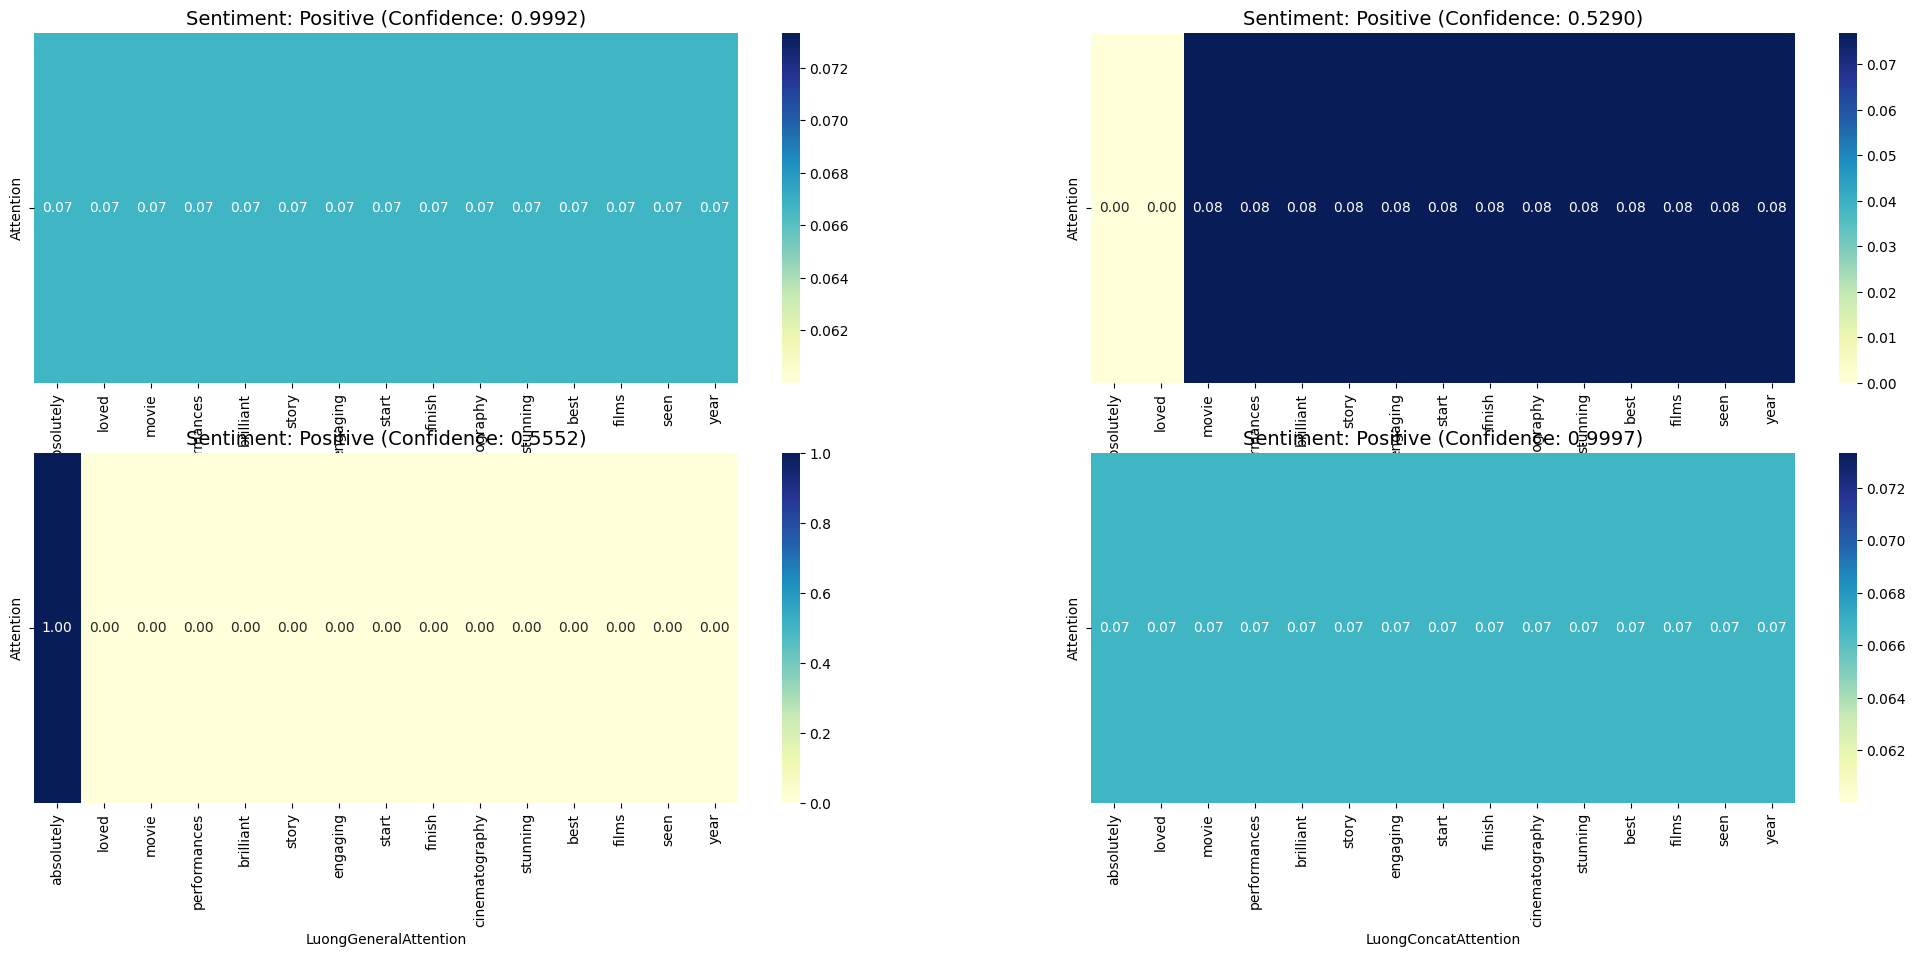

Saving /positive/VanillaRNNWithPlugAndPlayAttention
<class 'models_with_attention.VanillaBidirectionalRNNWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9992)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5552)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9997)


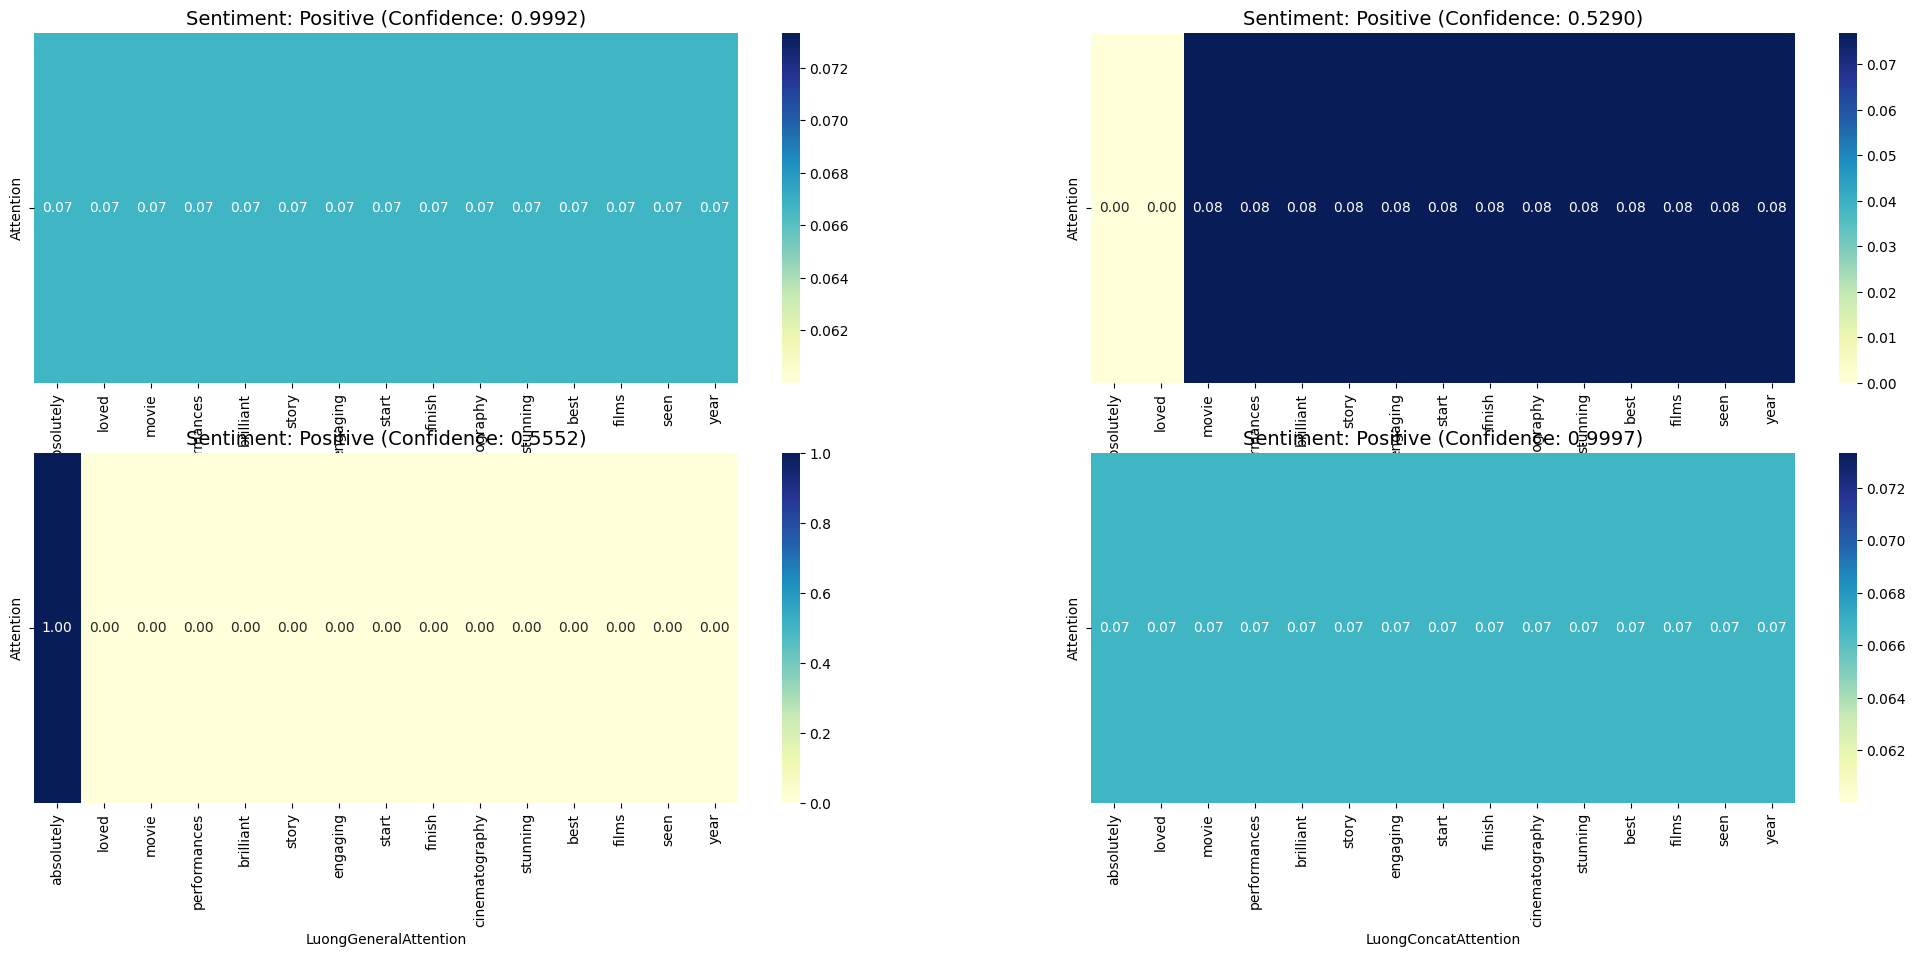

Saving /positive/VanillaBidirectionalRNNWithPlugAndPlayAttention
<class 'models_with_attention.VanillaLSTMWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9992)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5552)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9997)


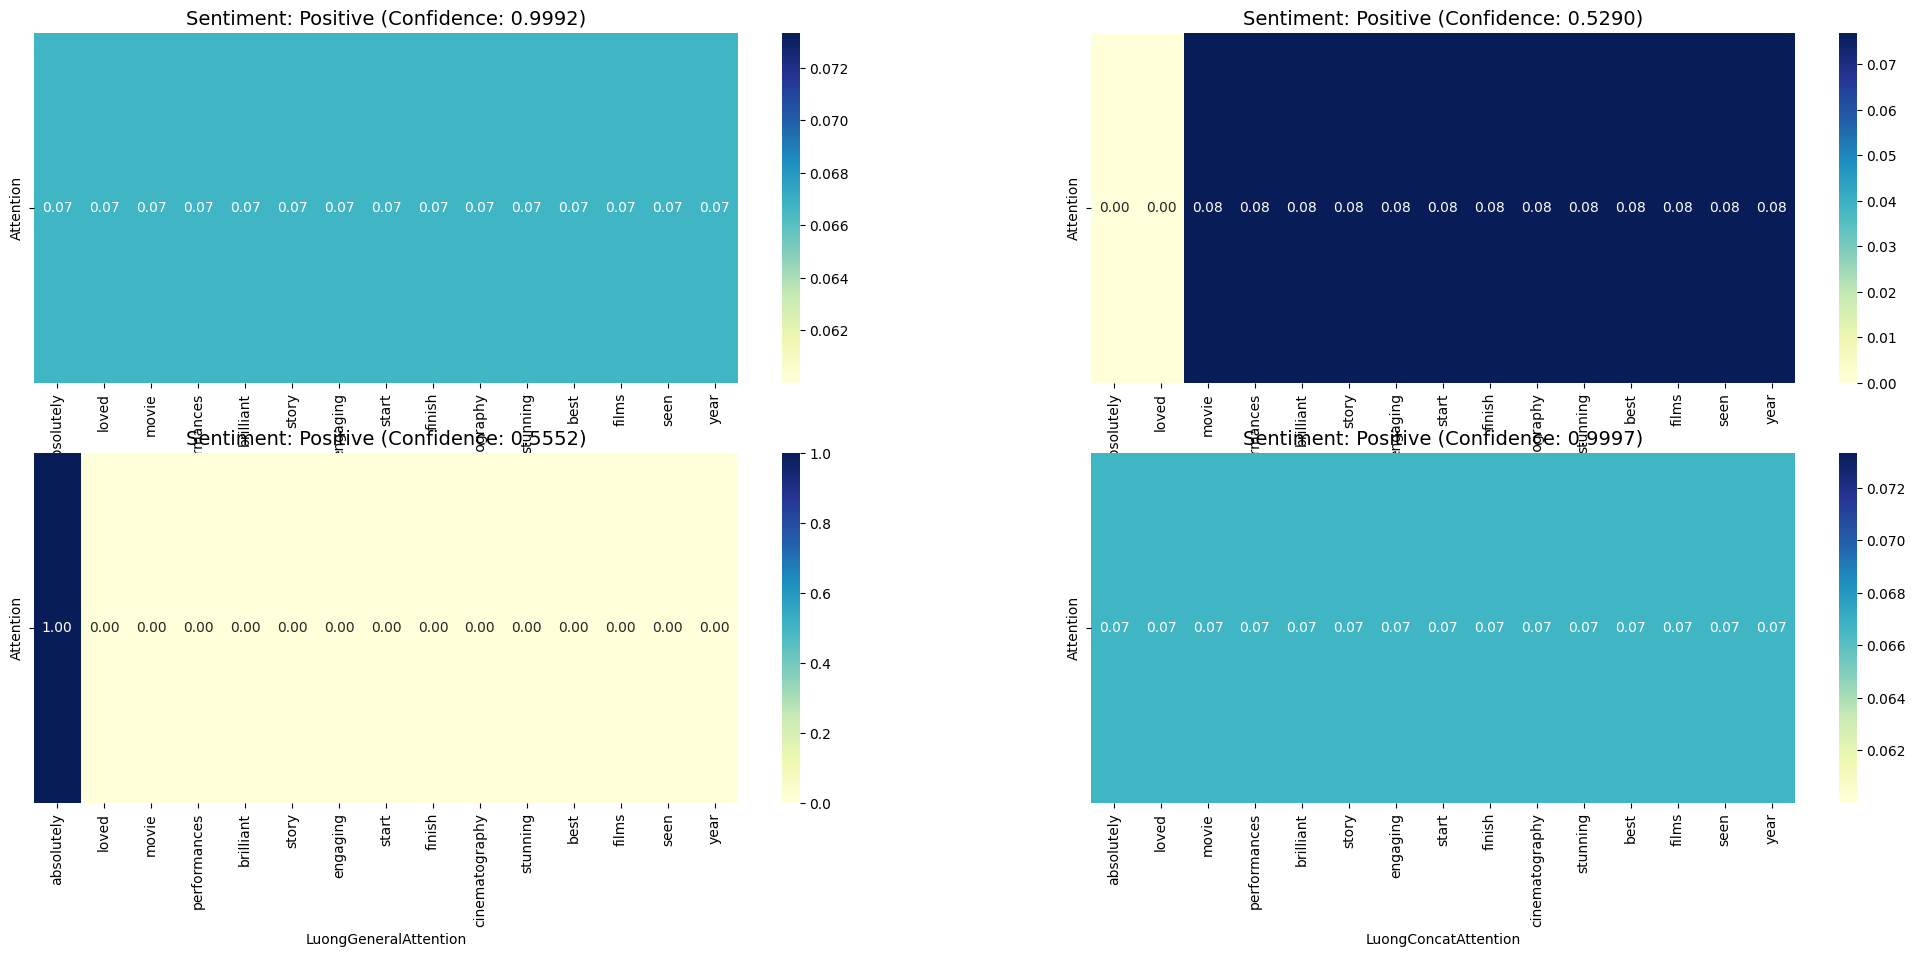

Saving /positive/VanillaLSTMWithPlugAndPlayAttention
<class 'models_with_attention.VanillaBidirectionalLSTMWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9992)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5552)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9997)


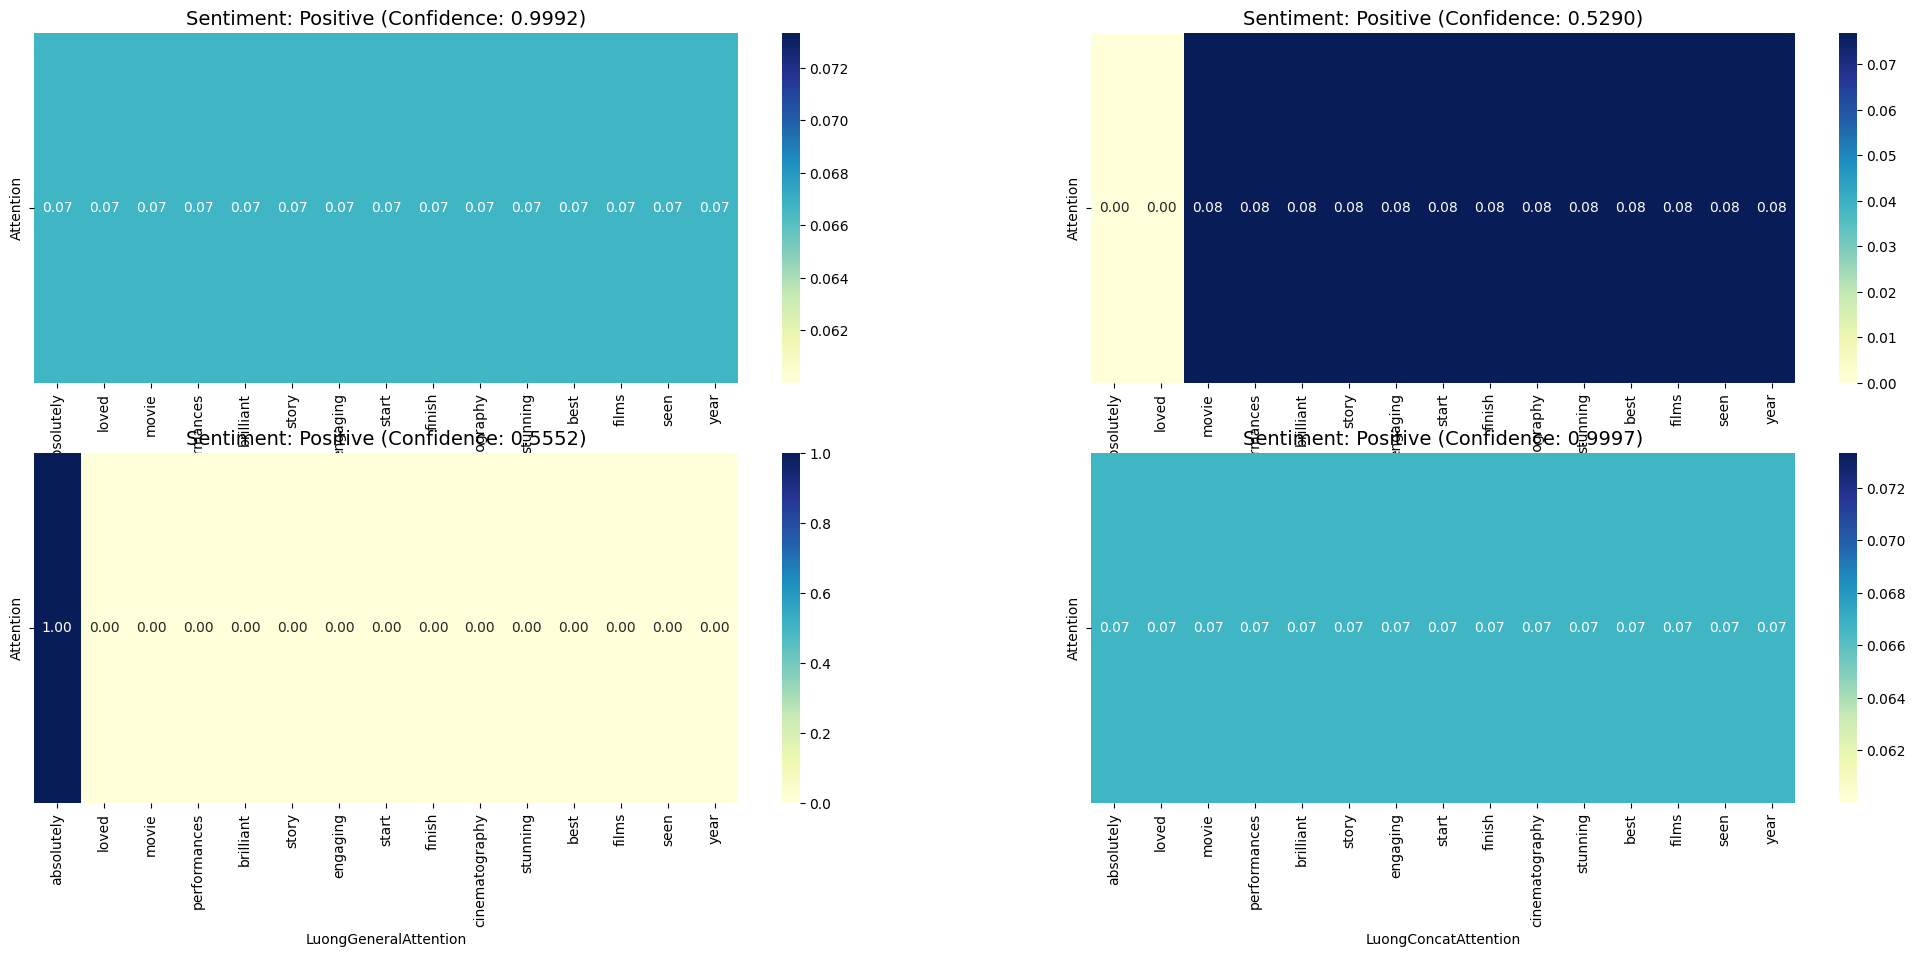

Saving /positive/VanillaBidirectionalLSTMWithPlugAndPlayAttention


In [ ]:
for plug_and_play_attention_model in plug_and_play_attention_models:
    print(plug_and_play_attention_model)

    fig = visualize_attention(plug_and_play_attention_model,positive_review)
    fig.savefig(f"./positive/{plug_and_play_attention_model.__name__}")
    print(f"Saving /positive/{plug_and_play_attention_model.__name__}")

<class 'models_with_attention.VanillaRNNWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0001)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5289)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.2096)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


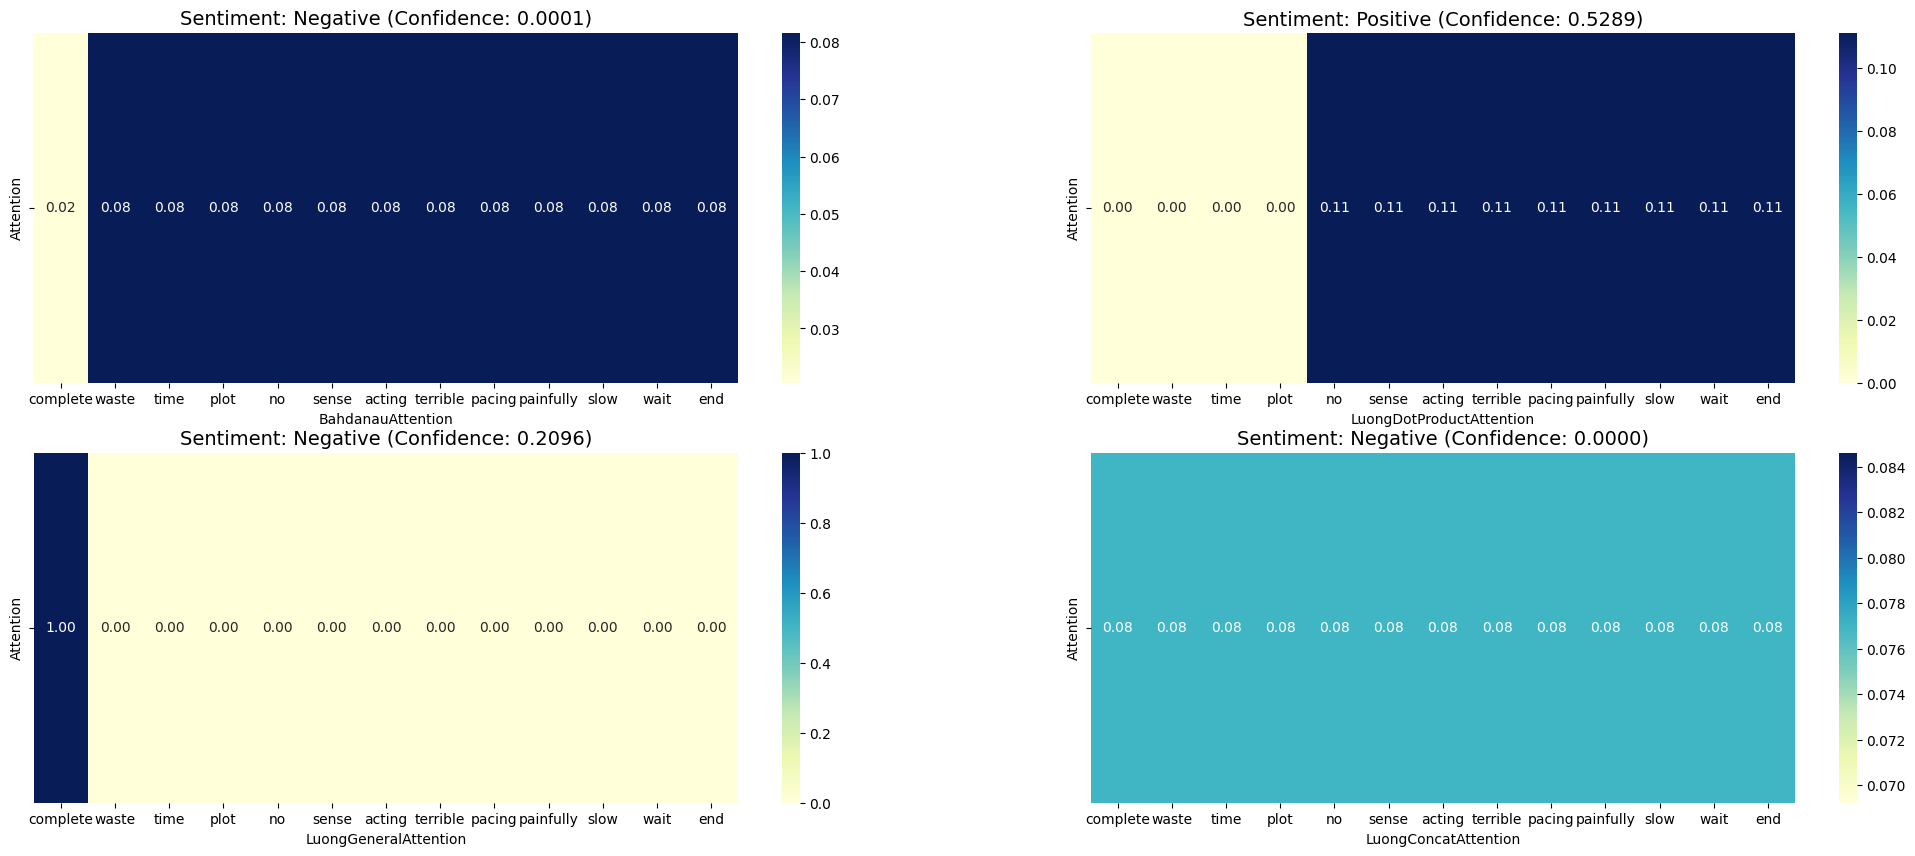

<class 'models_with_attention.VanillaBidirectionalRNNWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0001)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5289)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.2096)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


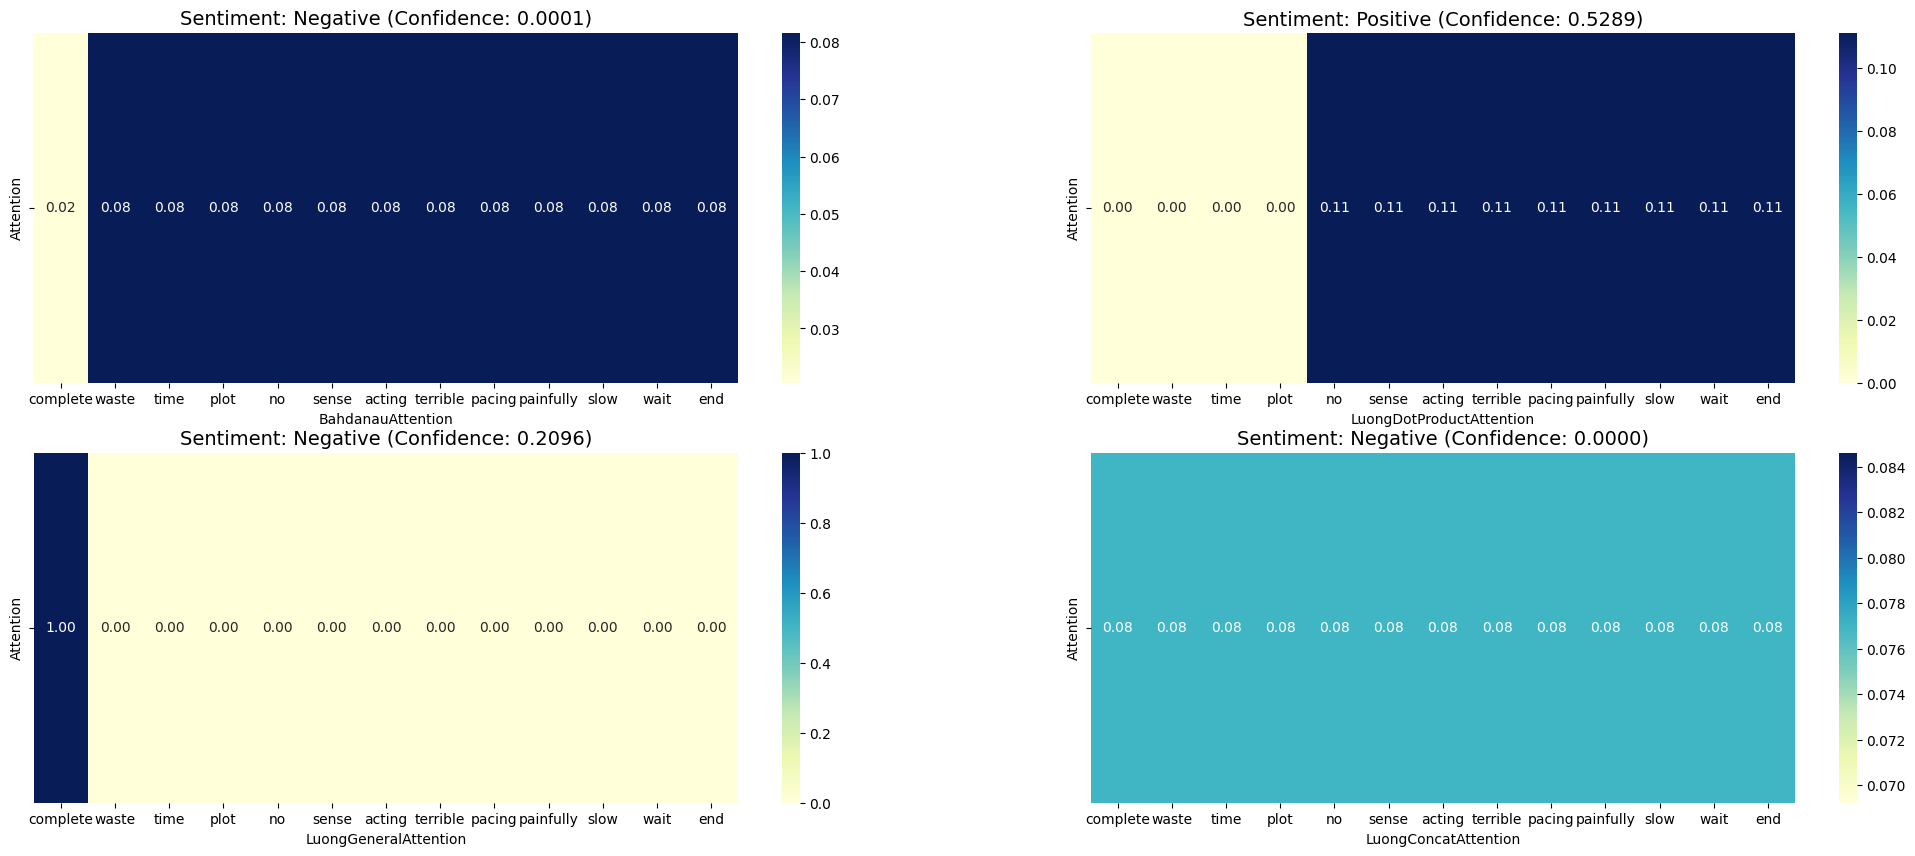

<class 'models_with_attention.VanillaLSTMWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0001)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5289)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.2096)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


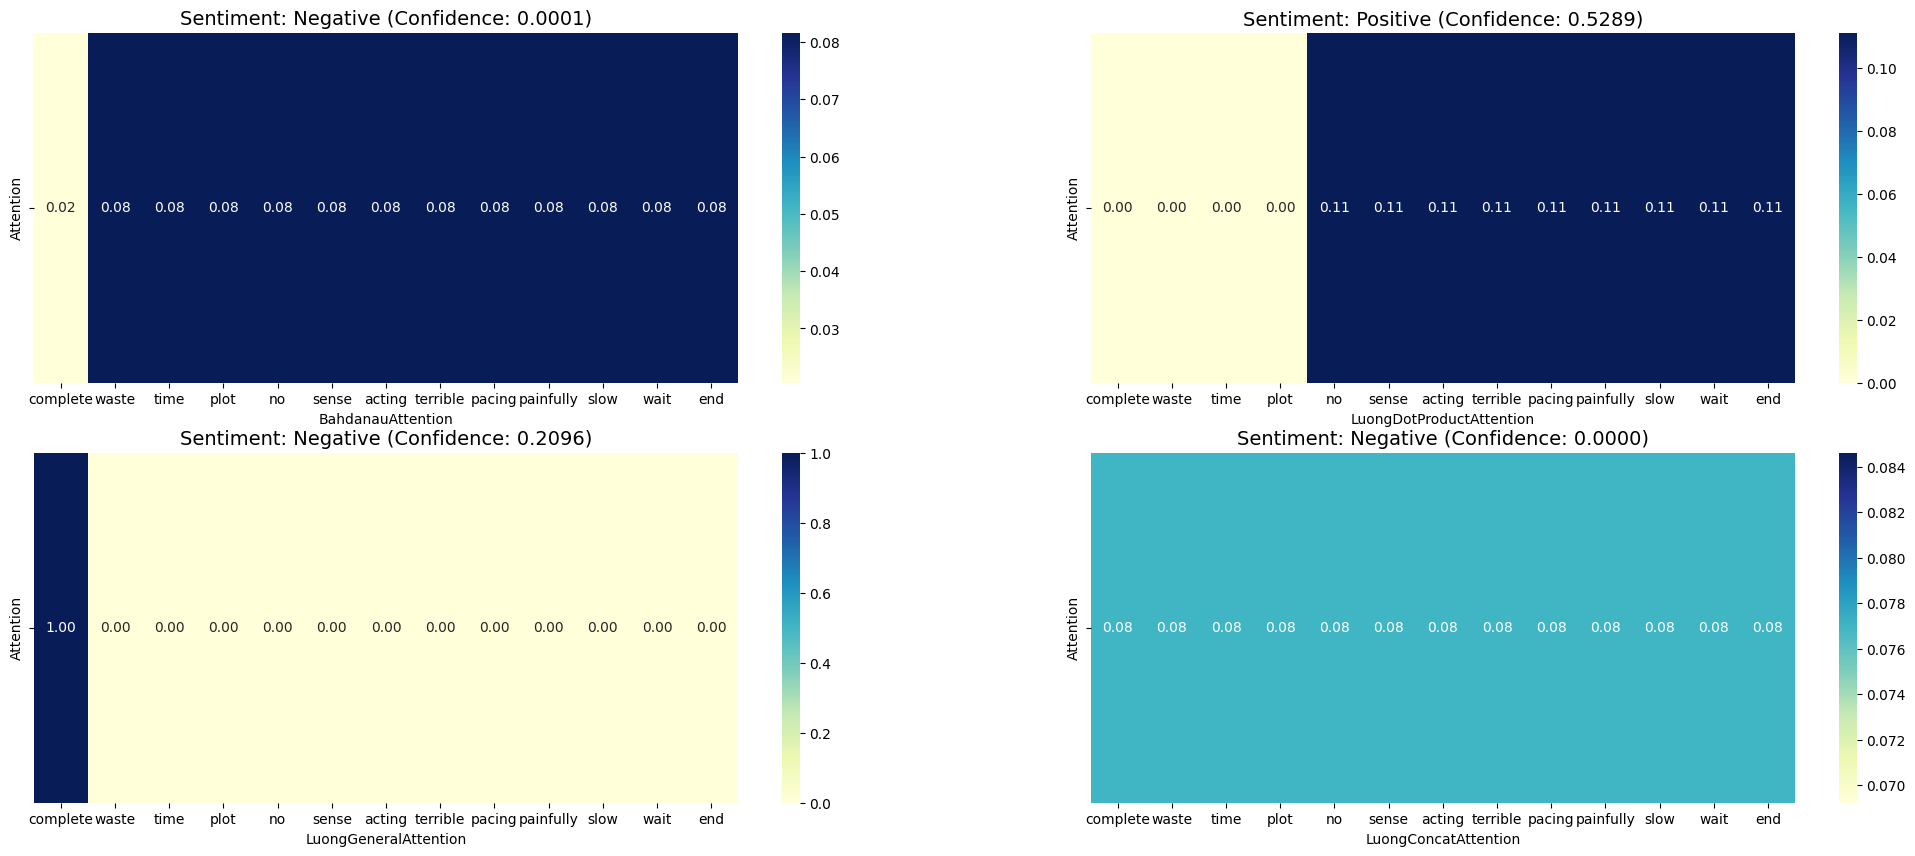

<class 'models_with_attention.VanillaBidirectionalLSTMWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0001)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5289)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.2096)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


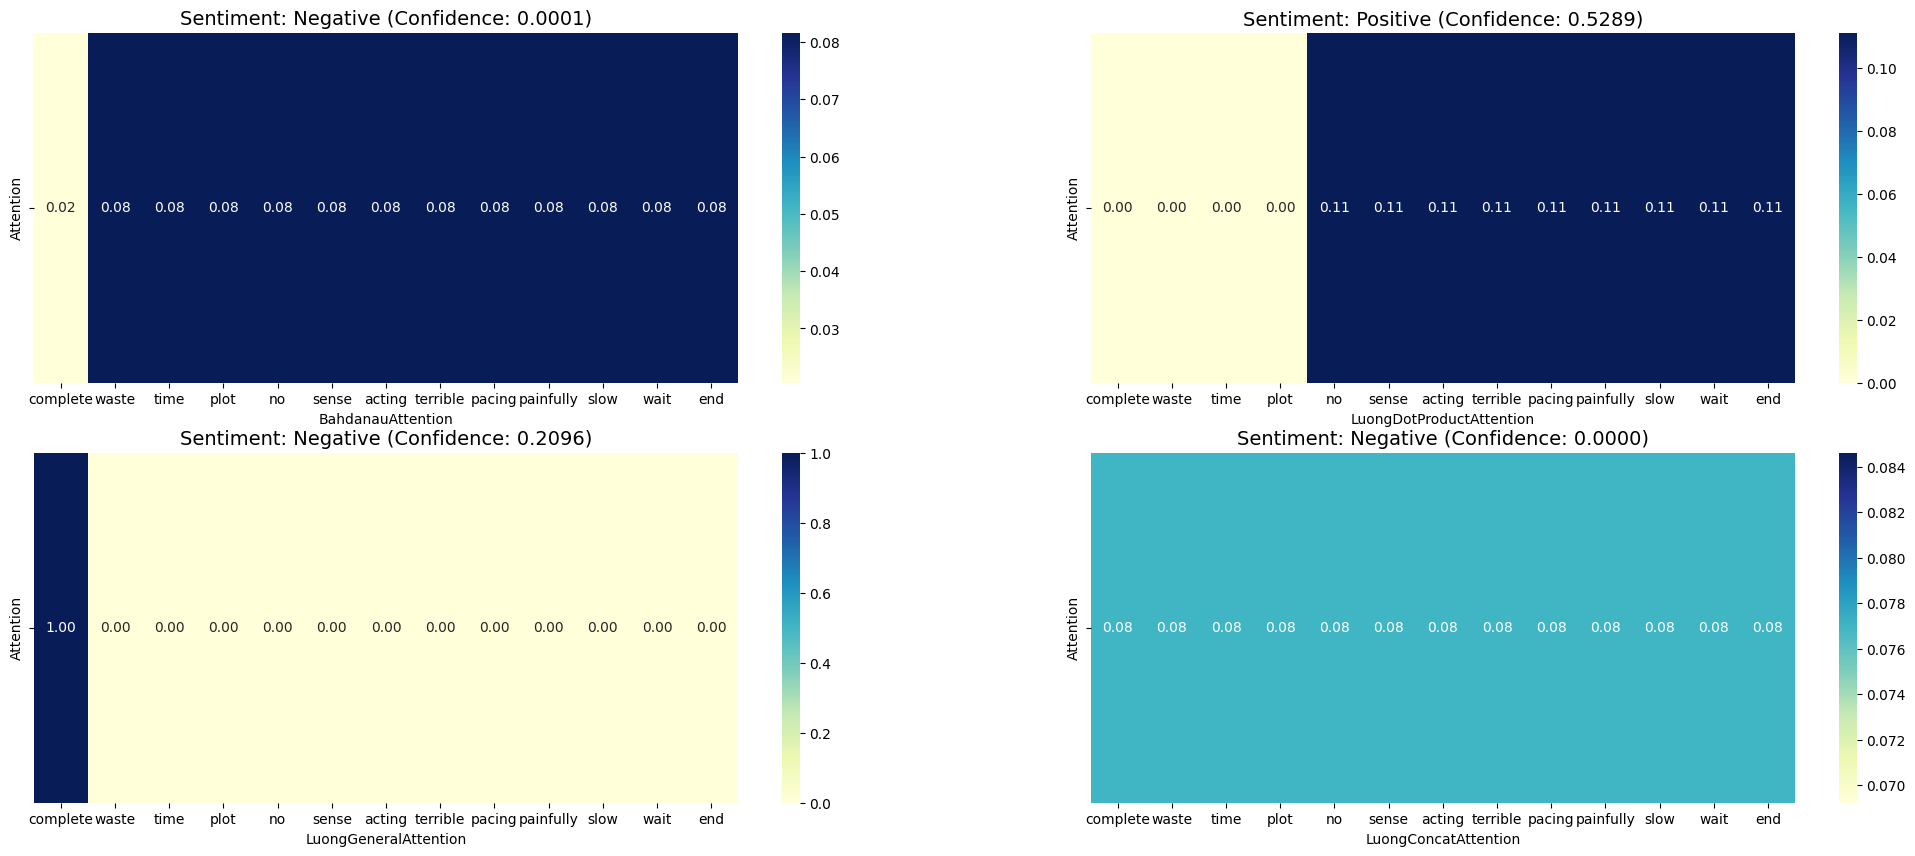

In [ ]:
for plug_and_play_attention_model in plug_and_play_attention_models:
    print(plug_and_play_attention_model)

    fig = visualize_attention(plug_and_play_attention_model,negative_review)
    fig.savefig(f"./negative/{plug_and_play_attention_model.__name__}")

<class 'models_with_attention.VanillaRNNWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9836)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3716)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8219)


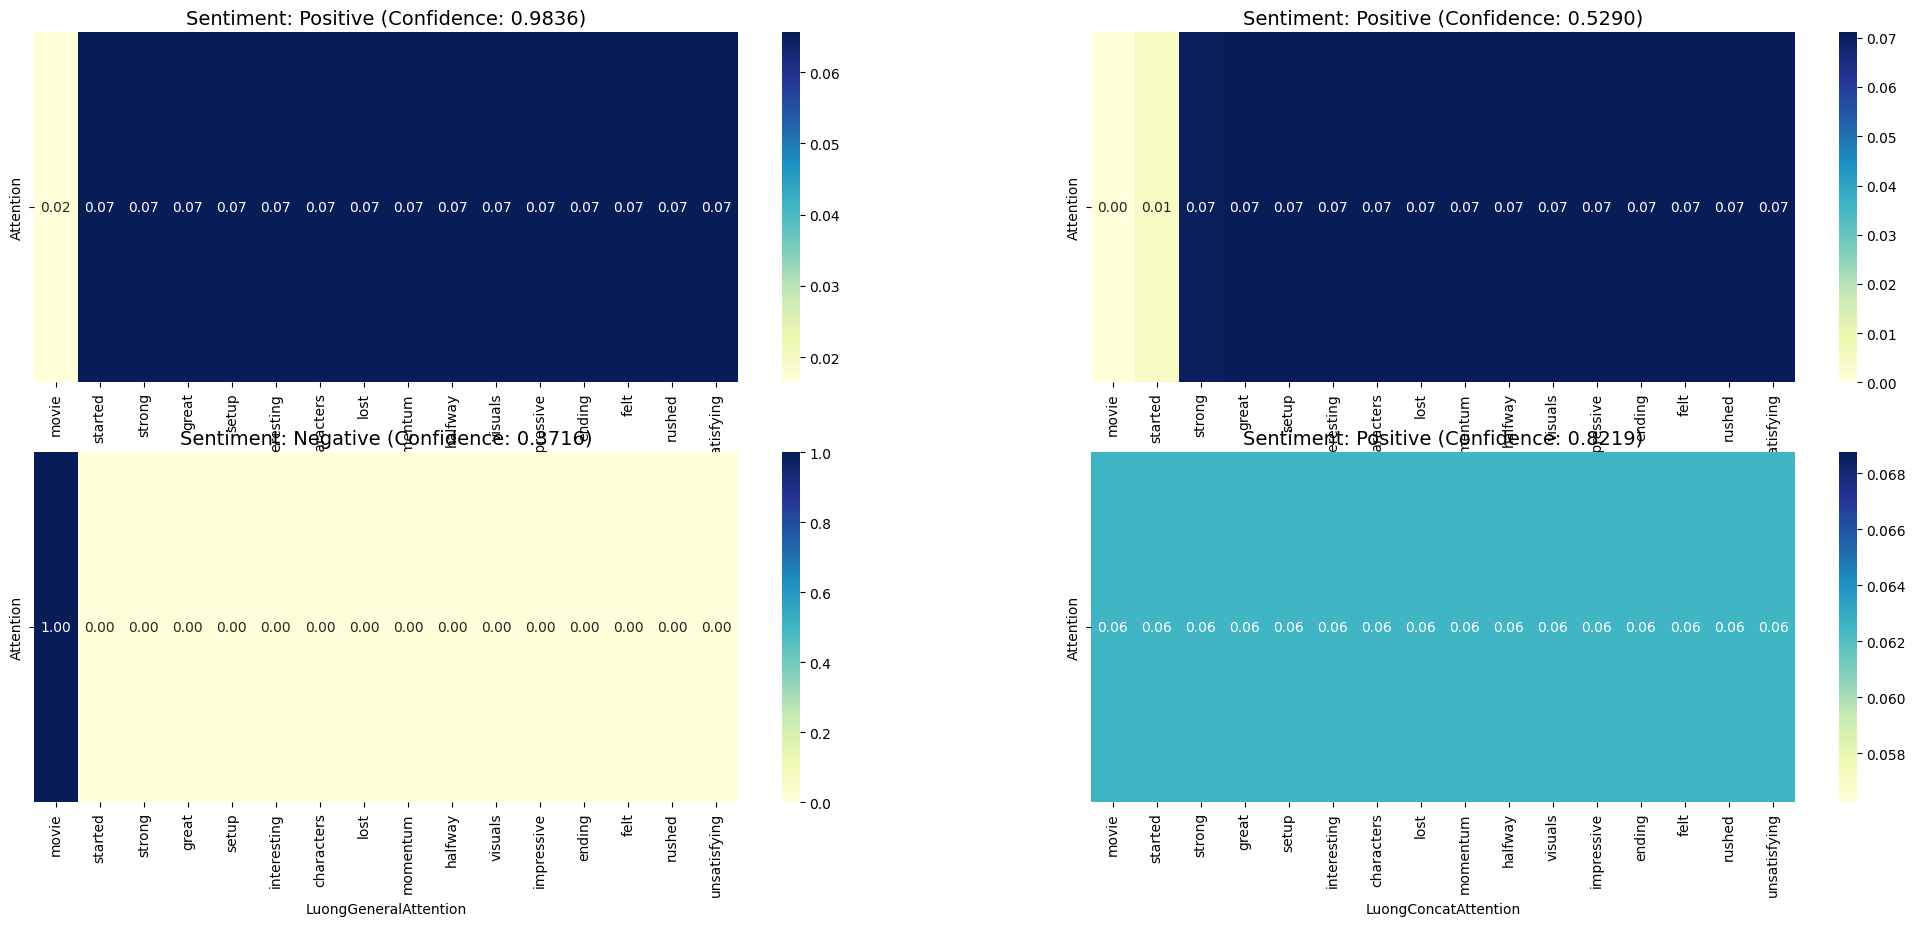

<class 'models_with_attention.VanillaBidirectionalRNNWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9836)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3716)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8219)


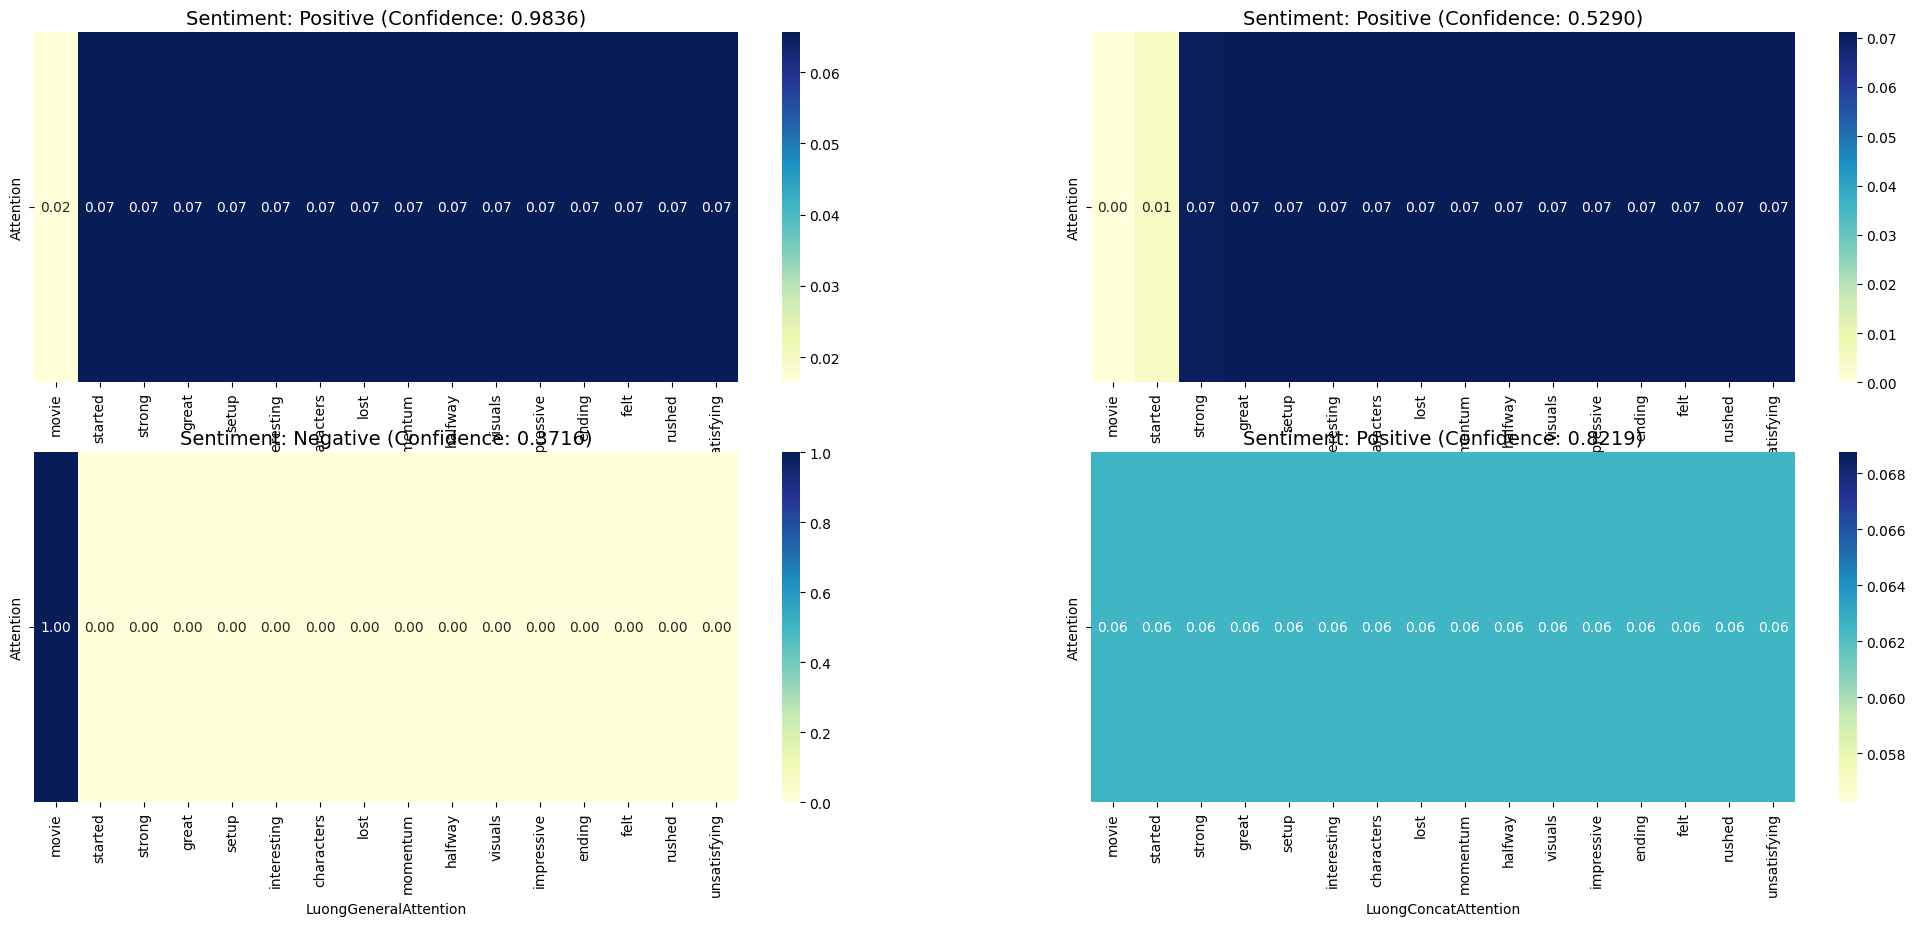

<class 'models_with_attention.VanillaLSTMWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9836)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3716)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8219)


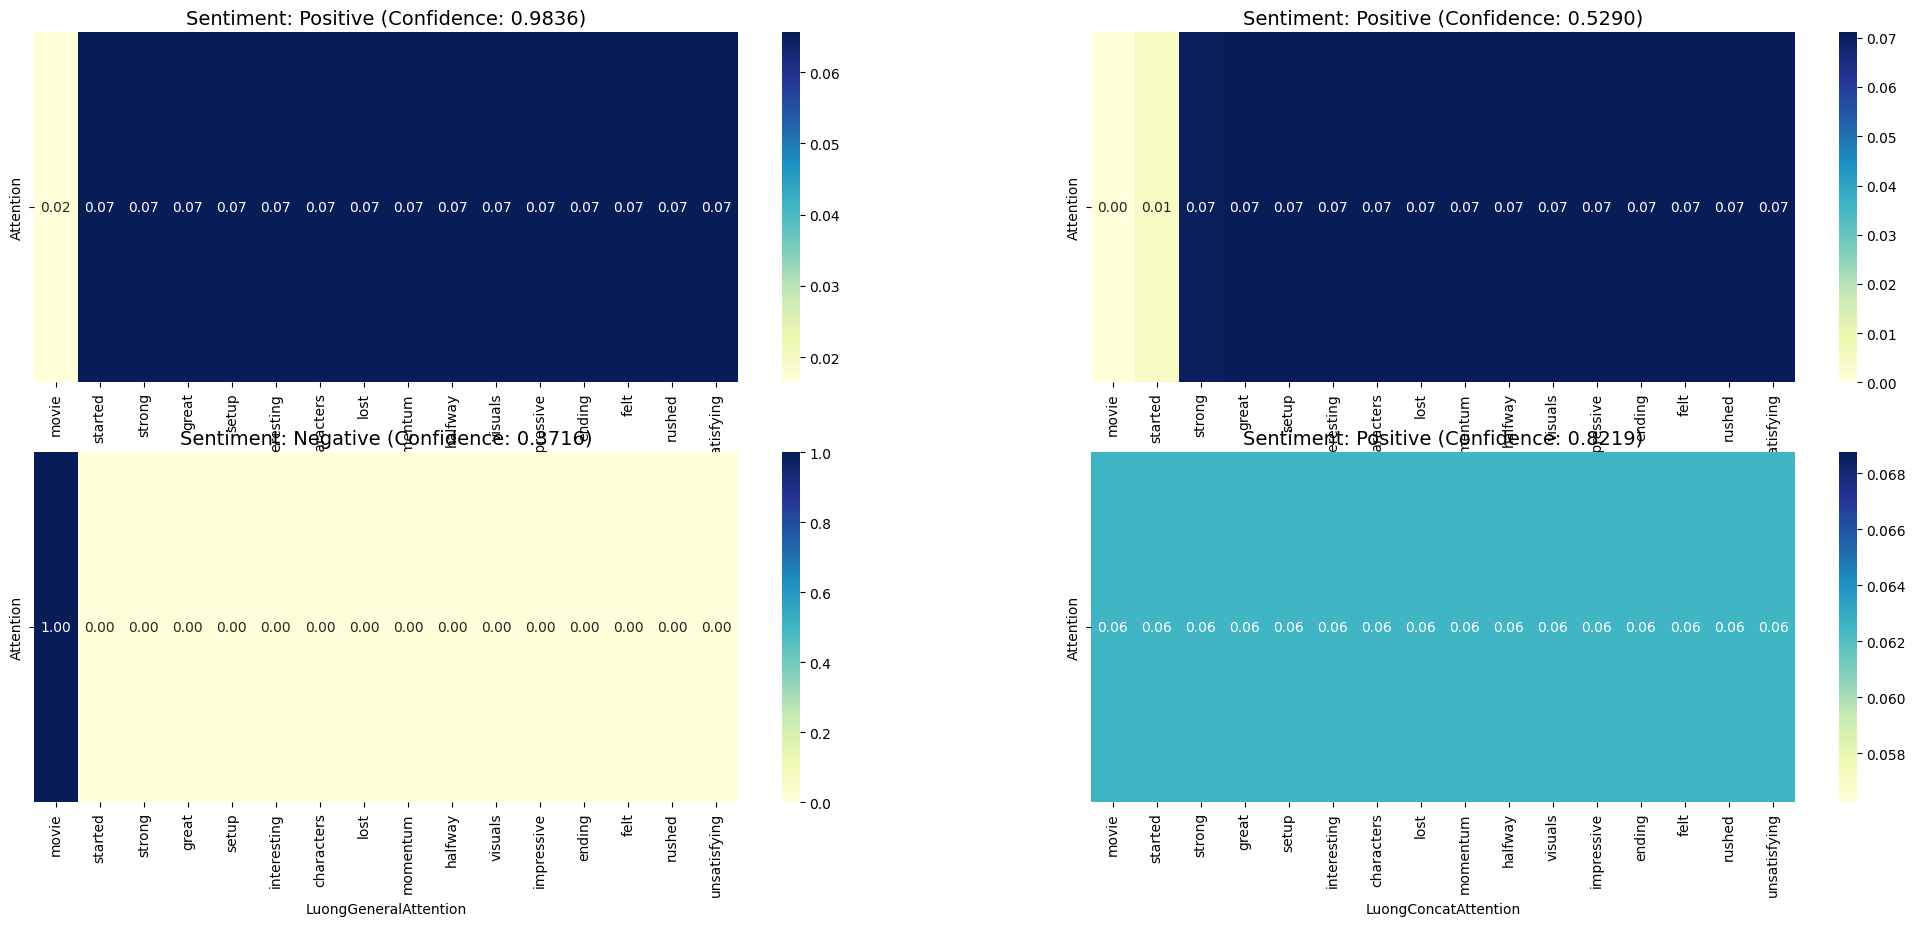

<class 'models_with_attention.VanillaBidirectionalLSTMWithPlugAndPlayAttention'>
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9836)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3716)
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8219)


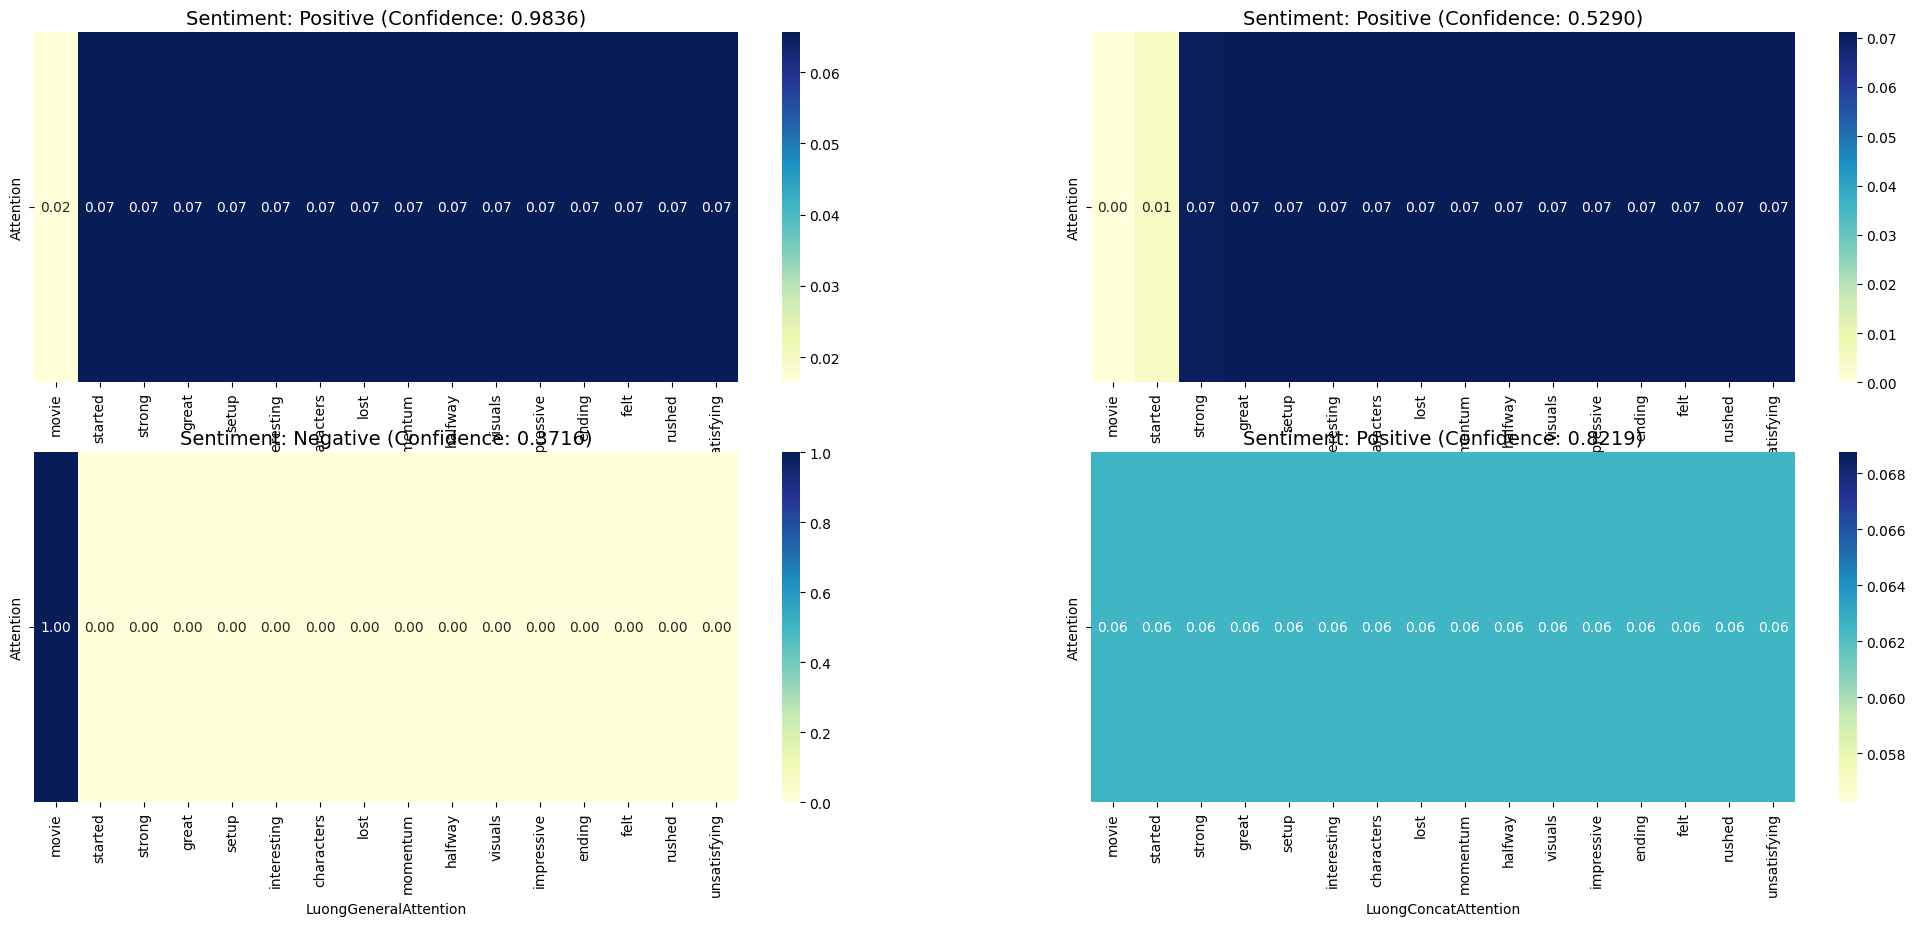

In [ ]:
for plug_and_play_attention_model in plug_and_play_attention_models:
    print(plug_and_play_attention_model)

    fig = visualize_attention(plug_and_play_attention_model,mixed_review)
    fig.savefig(f"./mixed/{plug_and_play_attention_model.__name__}")


--- Training VanillaRNNWithBahdanauAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9836)


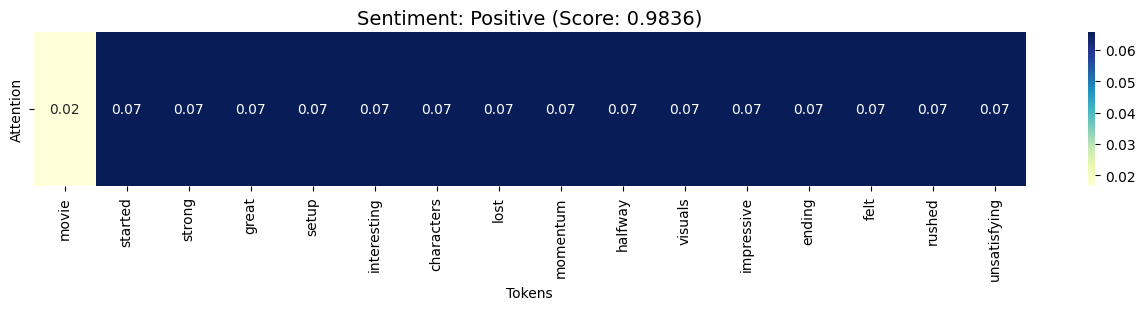


--- Training VanillaRNNWithLuongDotProductAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)


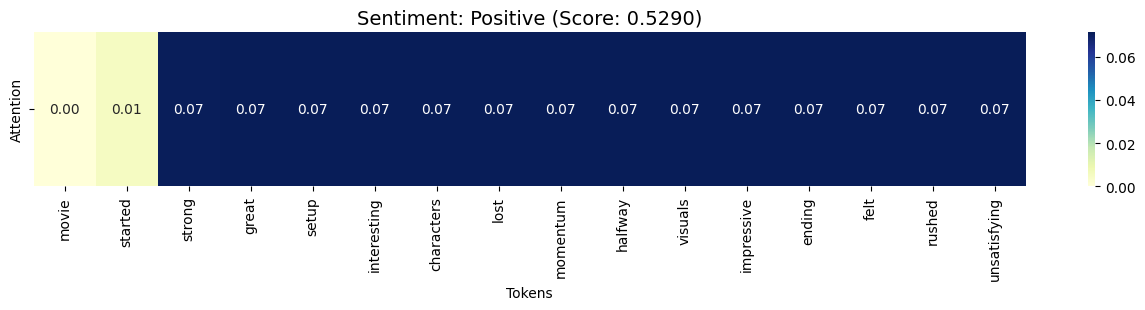


--- Training VanillaRNNWithLuongGeneralAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3716)


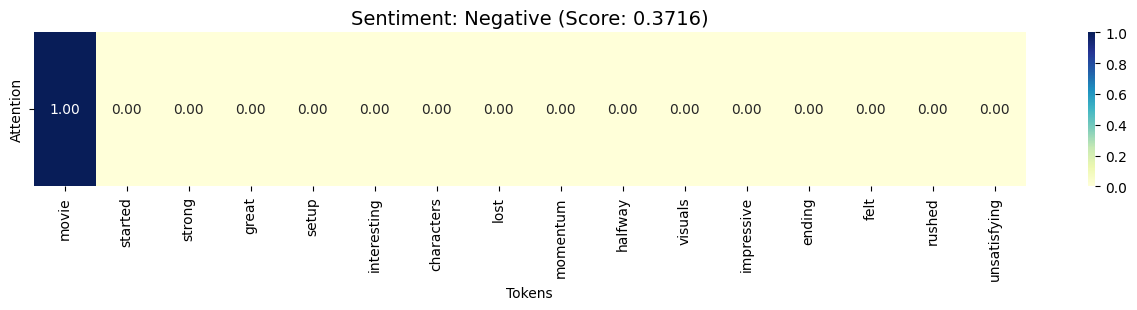


--- Training VanillaRNNWithLuongConcatAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8219)


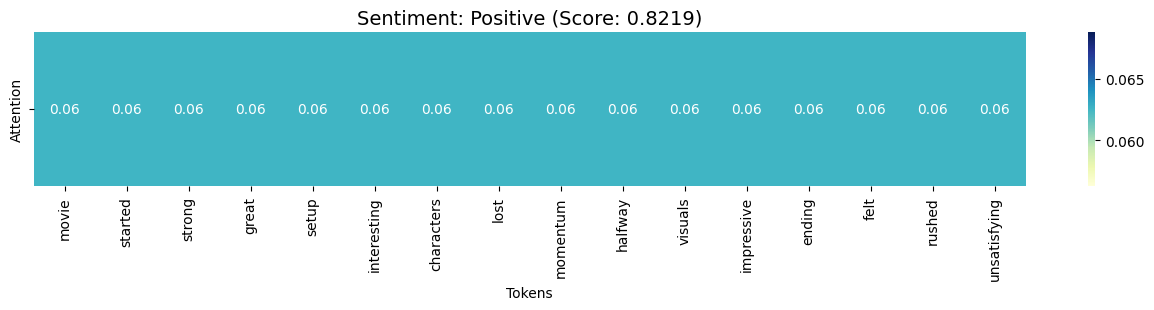


--- Training VanillaBidirectionalRNNWithBahdanauAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8611)


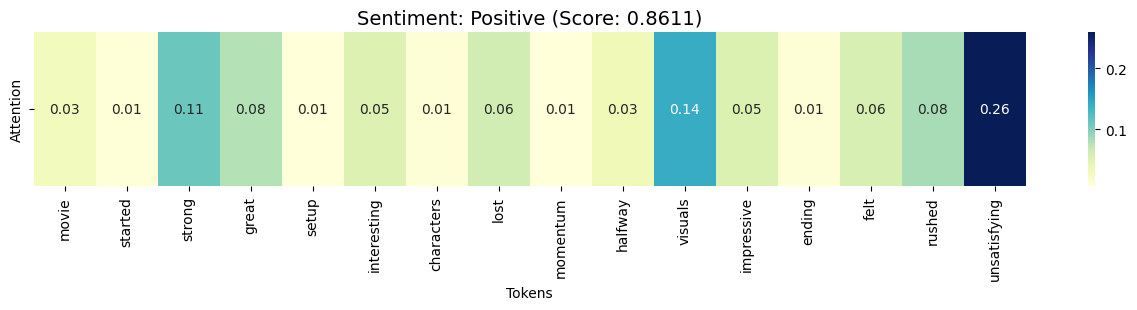


--- Training VanillaBidirectionalRNNWithLuongDotProductAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8982)


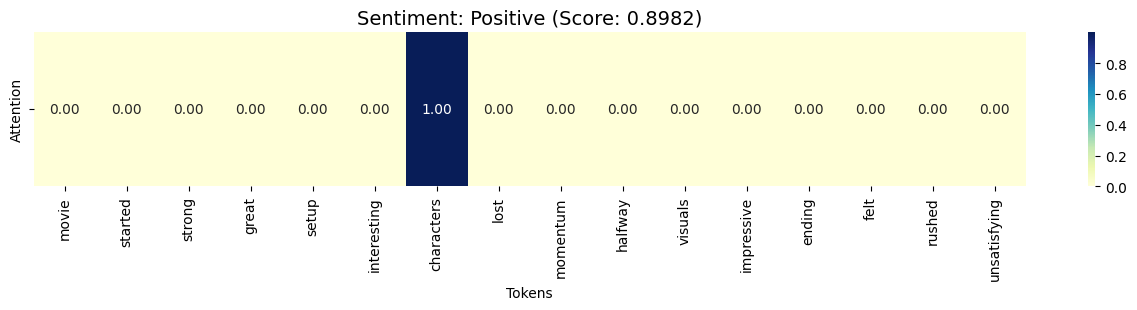


--- Training VanillaBidirectionalRNNWithLuongGeneralAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.1186)


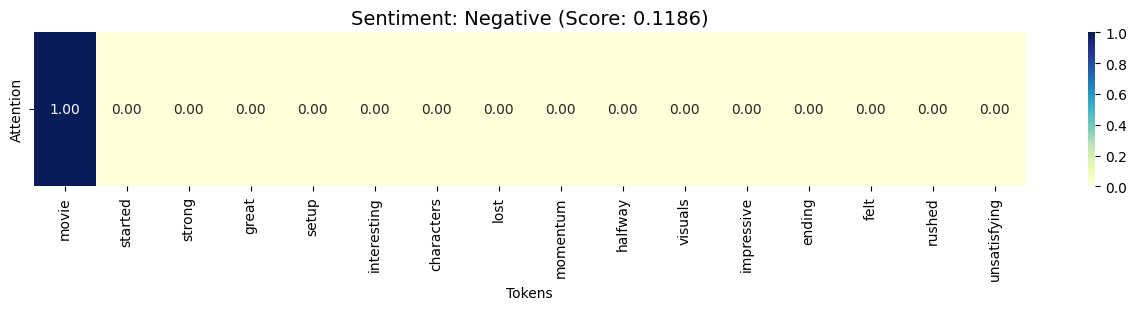


--- Training VanillaBidirectionalRNNWithLuongConcatAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9999)


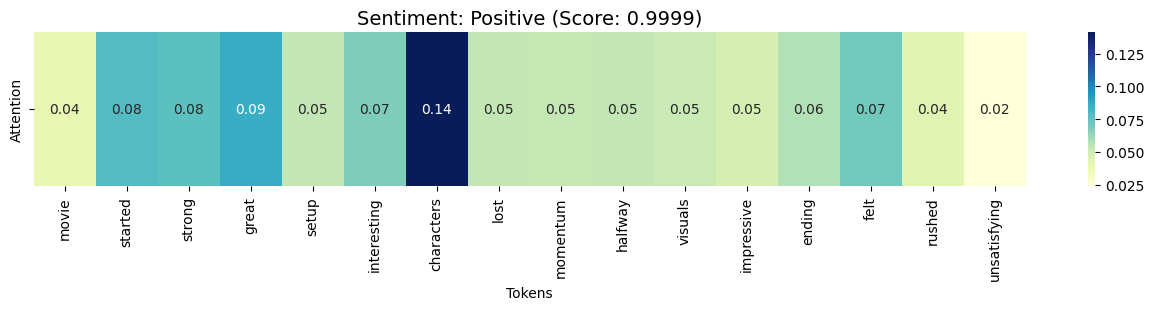


--- Training VanillaLSTMWithBahdanauAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.7669)


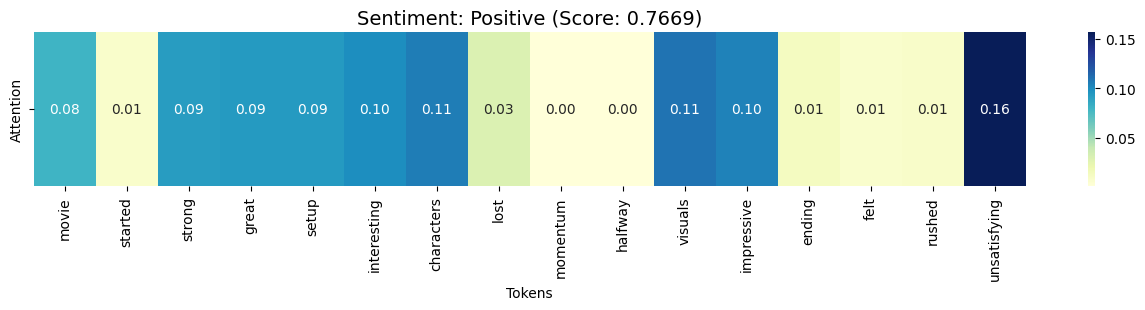


--- Training VanillaLSTMWithLuongDotProductAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.4853)


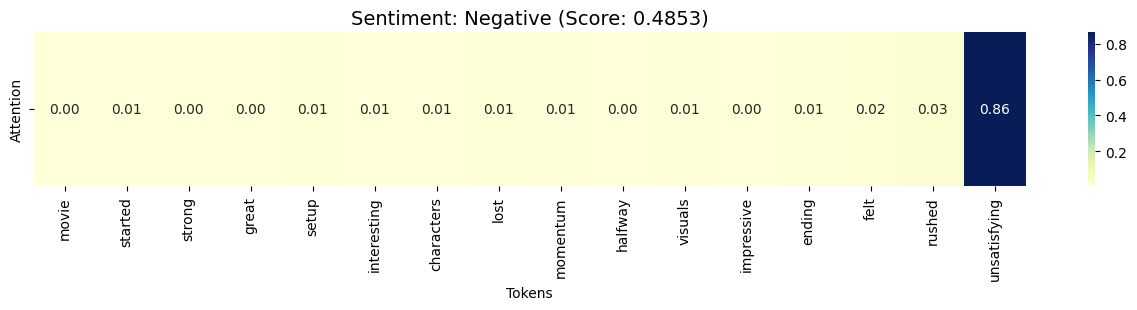


--- Training VanillaLSTMWithLuongGeneralAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.6584)


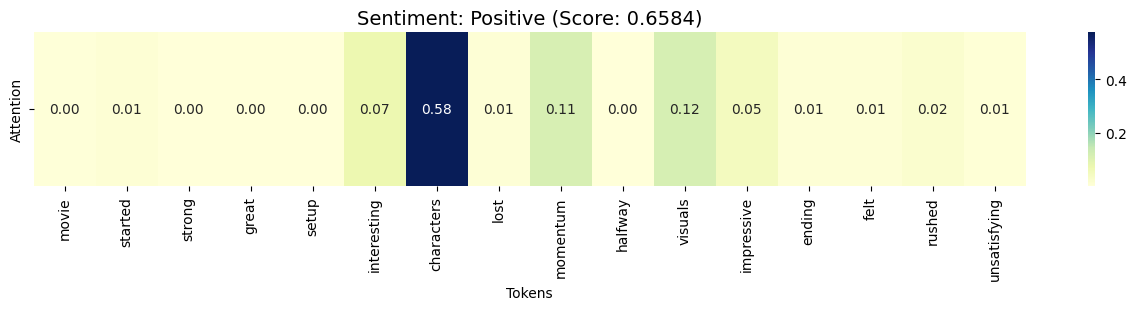


--- Training VanillaLSTMWithLuongConcatAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9116)


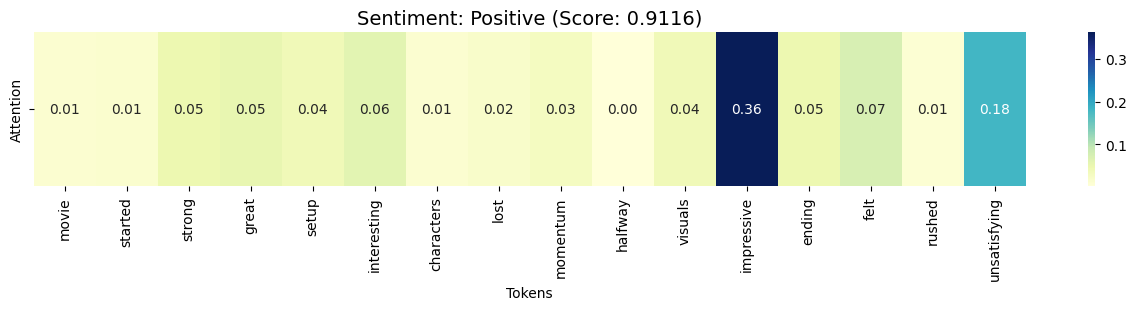


--- Training VanillaBidirectionalLSTMWithBahdanauAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8916)


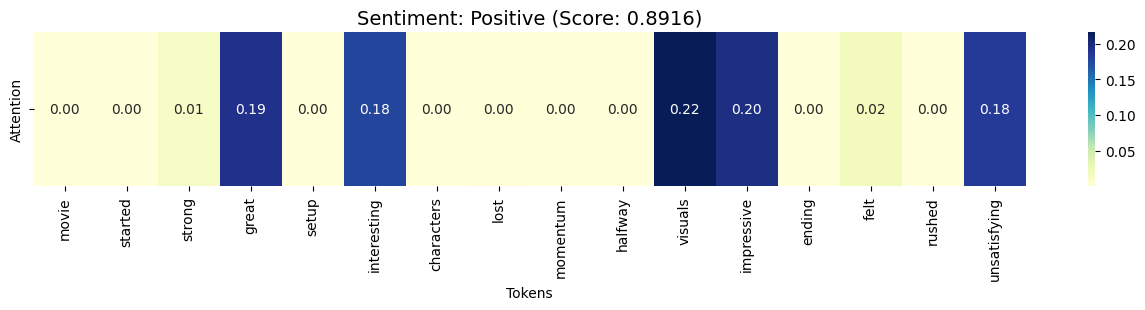


--- Training VanillaBidirectionalLSTMWithLuongDotProductAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0625)


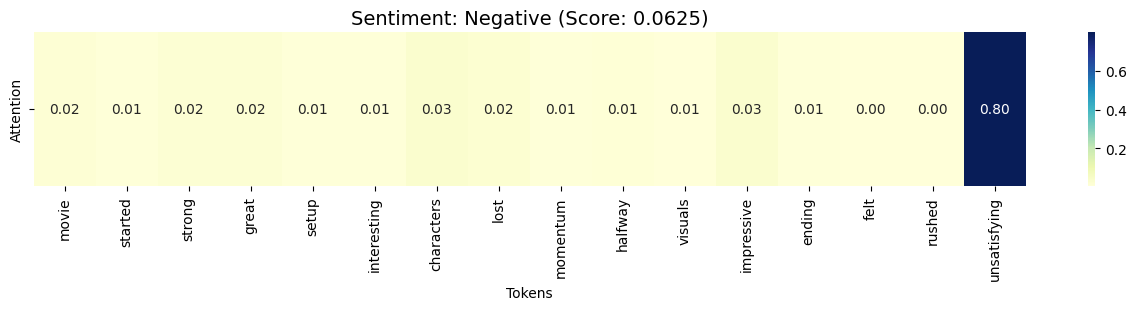


--- Training VanillaBidirectionalLSTMWithLuongGeneralAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3540)


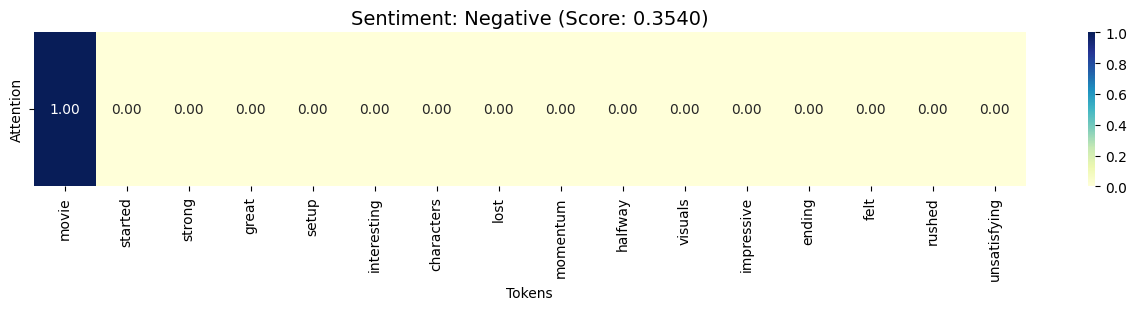


--- Training VanillaBidirectionalLSTMWithLuongConcatAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.7149)


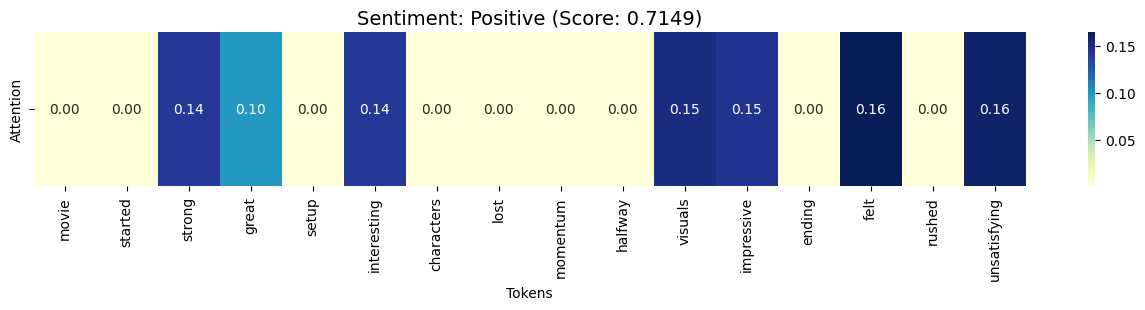

In [ ]:
# Positive Review
positive_review = "I absolutely loved this movie. The performances were brilliant, the story was engaging from start to finish, and the cinematography was stunning. One of the best films I’ve seen this year!"


for pap_a_model in plug_and_play_attention_models:
    for attention_type, attention_kwarg in zip(attention_types, attention_kwargs):
        base_model_name = pap_a_model.__name__.replace("WithPlugAndPlayAttention", "")
        attn_name = attention_type.__name__.replace("Attention", "")
        full_model_name = f"{base_model_name}With{attn_name}Attention"
        
        print(f"\n--- Training {full_model_name} ---")

        model_path = f"./saved_models/{full_model_name}/best_model.pth"
        state_dict = torch.load(model_path)

        model = pap_a_model(
            embedding_matrix=embedding_matrix_tensor,
            attention_class=attention_type,
            attention_kwargs=attention_kwarg,
            hidden_dim=HIDDEN_DIM,
            freeze_embeddings=True
        ).to(device)


        model.load_state_dict(state_dict)
        fig = visualize_attention_for_review(sample_review,pap_a_model,attention_type,attention_kwarg,model_path)
        fig.savefig(f"./positive/{full_model_name}.png")
        



Directory './positive/' already exists.

--- Training VanillaRNNWithBahdanauAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0001)


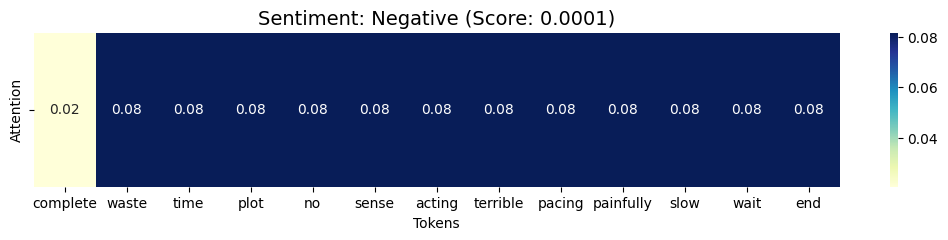


--- Training VanillaRNNWithLuongDotProductAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5289)


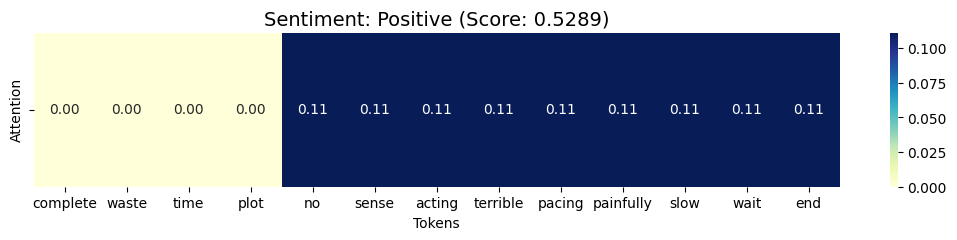


--- Training VanillaRNNWithLuongGeneralAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.2096)


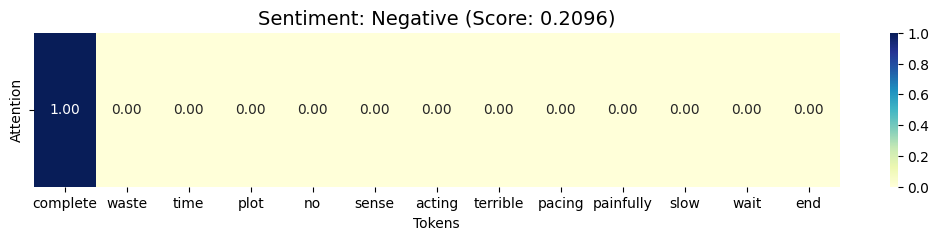


--- Training VanillaRNNWithLuongConcatAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


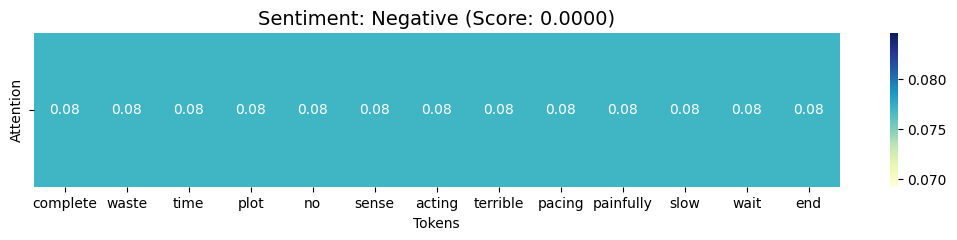


--- Training VanillaBidirectionalRNNWithBahdanauAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0004)


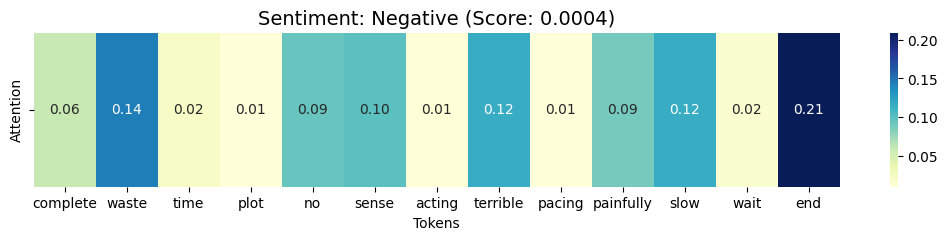


--- Training VanillaBidirectionalRNNWithLuongDotProductAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8908)


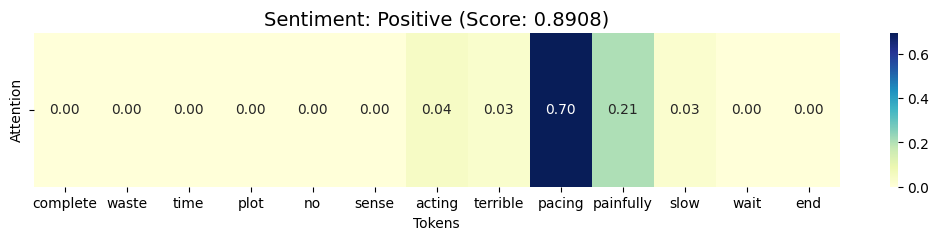


--- Training VanillaBidirectionalRNNWithLuongGeneralAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.1080)


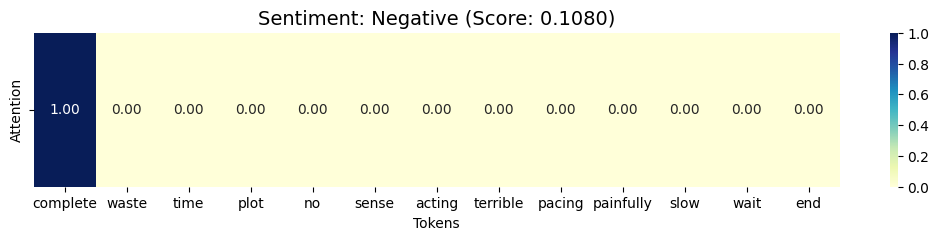


--- Training VanillaBidirectionalRNNWithLuongConcatAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


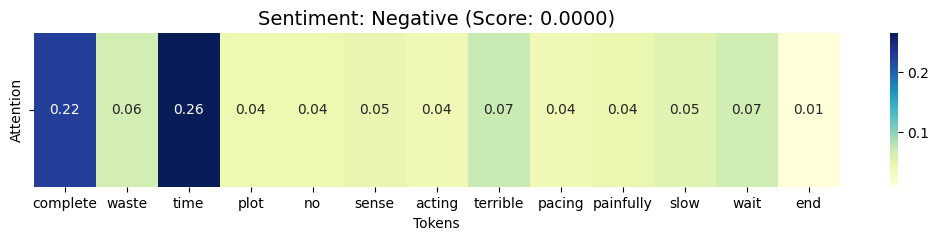


--- Training VanillaLSTMWithBahdanauAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


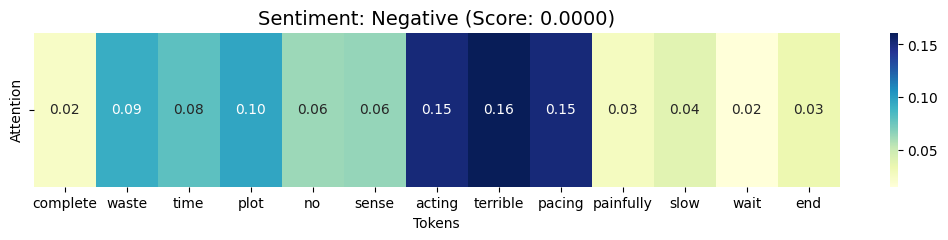


--- Training VanillaLSTMWithLuongDotProductAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


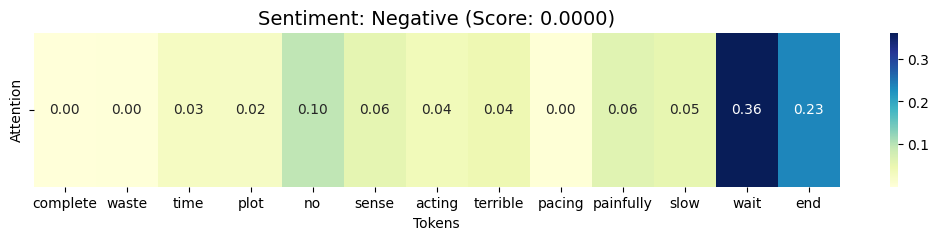


--- Training VanillaLSTMWithLuongGeneralAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0013)


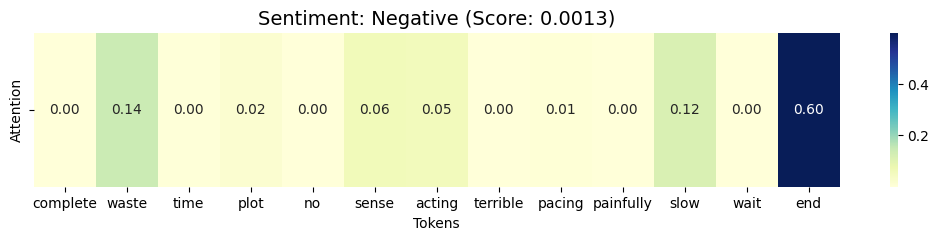


--- Training VanillaLSTMWithLuongConcatAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0008)


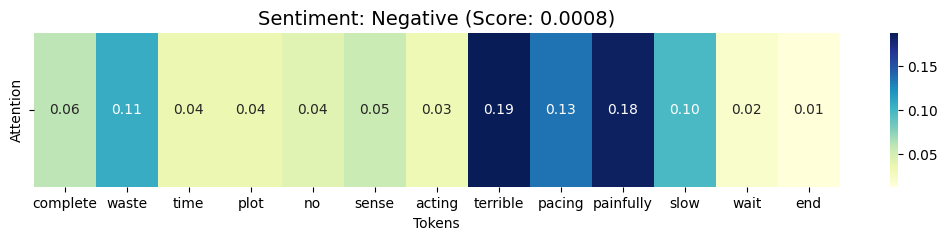


--- Training VanillaBidirectionalLSTMWithBahdanauAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


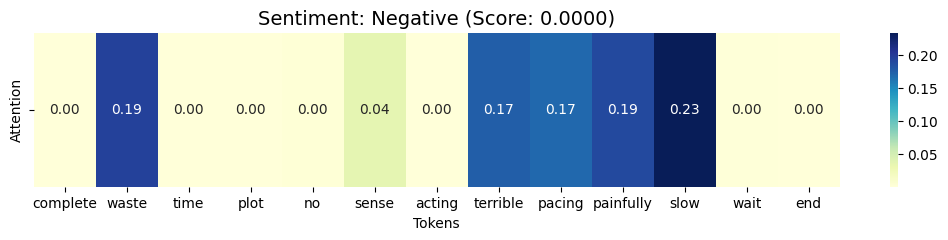


--- Training VanillaBidirectionalLSTMWithLuongDotProductAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


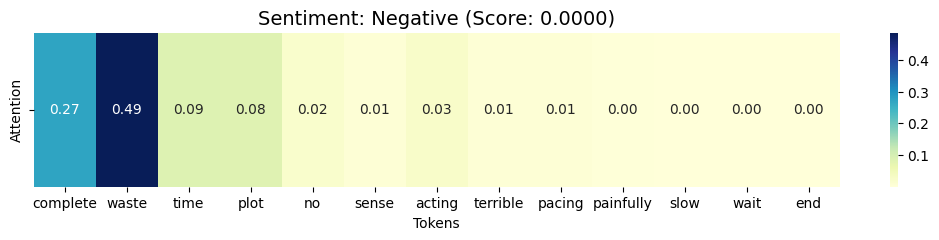


--- Training VanillaBidirectionalLSTMWithLuongGeneralAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0020)


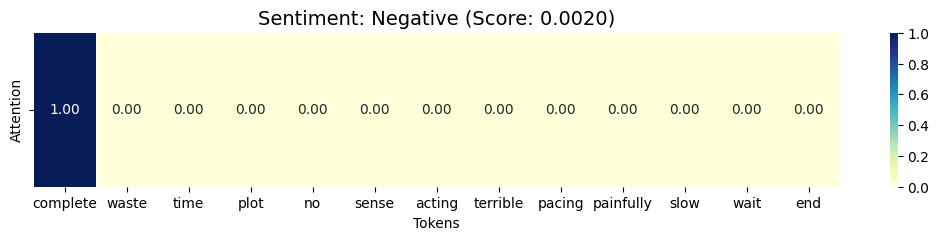


--- Training VanillaBidirectionalLSTMWithLuongConcatAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0000)


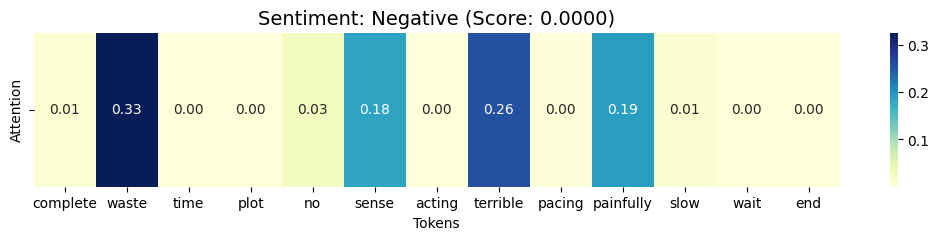

In [ ]:
# Negative Review
sample_review = "This was a complete waste of time. The plot made no sense, the acting was terrible, and the pacing was painfully slow. I couldn’t wait for it to end"

# Specify the directory path
output_dir = "./positive/"

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created successfully!")
else:
    print(f"Directory '{output_dir}' already exists.")


    
for pap_a_model in plug_and_play_attention_models:
    for attention_type, attention_kwarg in zip(attention_types, attention_kwargs):
        base_model_name = pap_a_model.__name__.replace("WithPlugAndPlayAttention", "")
        attn_name = attention_type.__name__.replace("Attention", "")
        full_model_name = f"{base_model_name}With{attn_name}Attention"
        
        print(f"\n--- Training {full_model_name} ---")

        model_path = f"./saved_models/{full_model_name}/best_model.pth"
        state_dict = torch.load(model_path)

        model = pap_a_model(
            embedding_matrix=embedding_matrix_tensor,
            attention_class=attention_type,
            attention_kwargs=attention_kwarg,
            hidden_dim=HIDDEN_DIM,
            freeze_embeddings=True
        ).to(device)


        model.load_state_dict(state_dict)
        fig = visualize_attention_for_review(sample_review,pap_a_model,attention_type,attention_kwarg,model_path)
        fig.savefig(f"./negative/{full_model_name}.png")
        



Unfortunately adjectives amplifier like "too" "very" are considered as stop words and are thus removed which I understand shouldn't be the case
* Need to improve upon this


--- Training VanillaRNNWithBahdanauAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9836)


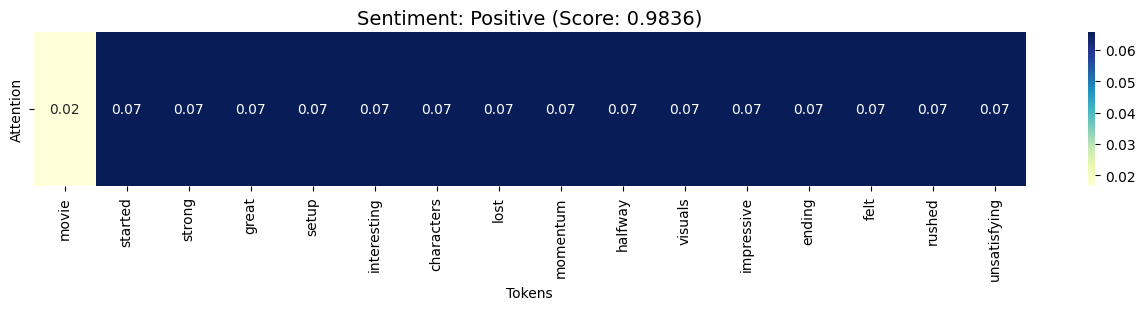


--- Training VanillaRNNWithLuongDotProductAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.5290)


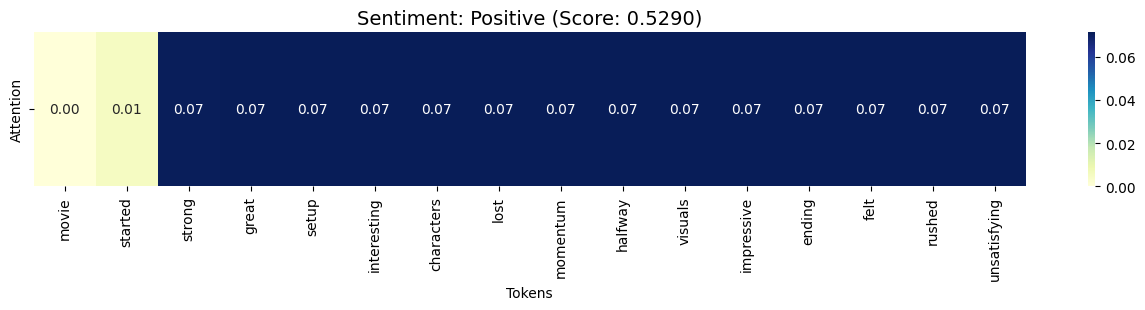


--- Training VanillaRNNWithLuongGeneralAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3716)


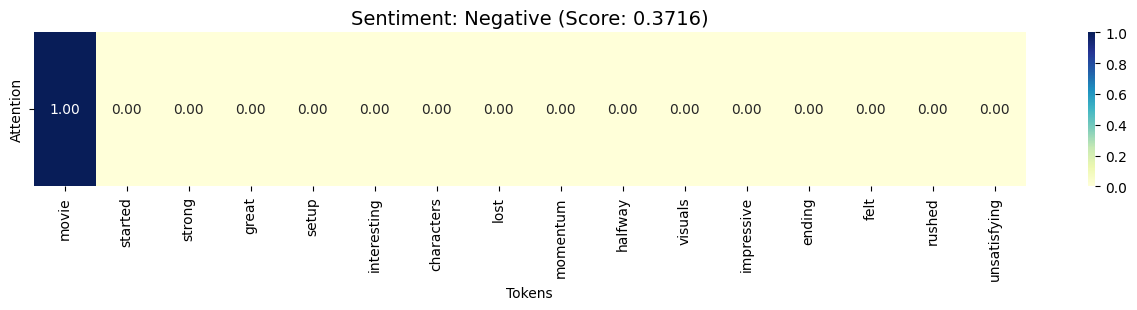


--- Training VanillaRNNWithLuongConcatAttention ---
Model : VanillaRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8219)


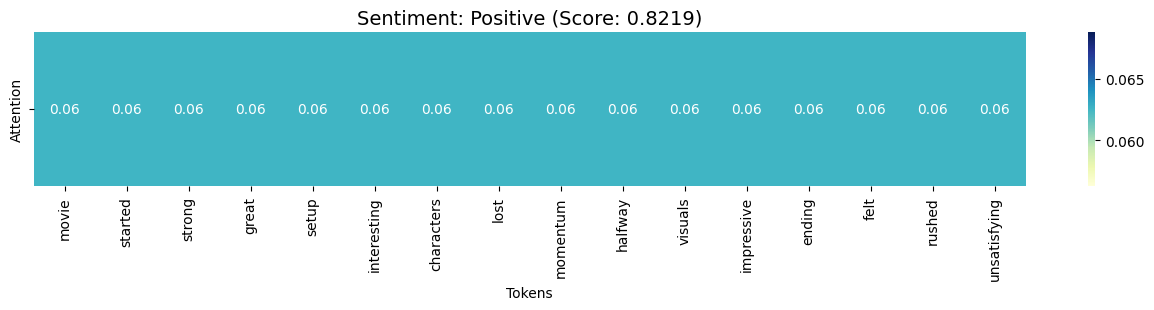


--- Training VanillaBidirectionalRNNWithBahdanauAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8611)


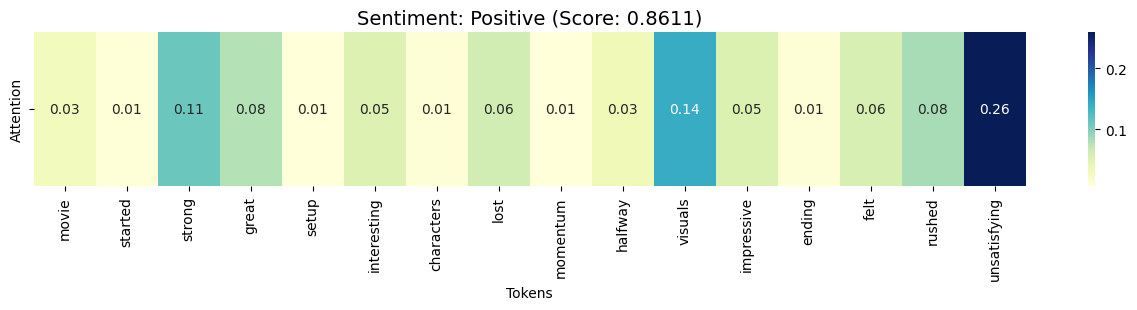


--- Training VanillaBidirectionalRNNWithLuongDotProductAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8982)


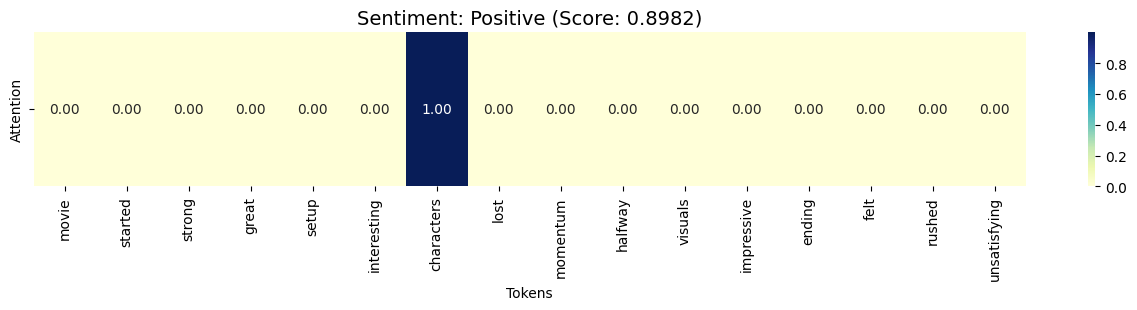


--- Training VanillaBidirectionalRNNWithLuongGeneralAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Negative (Score: 0.1186)


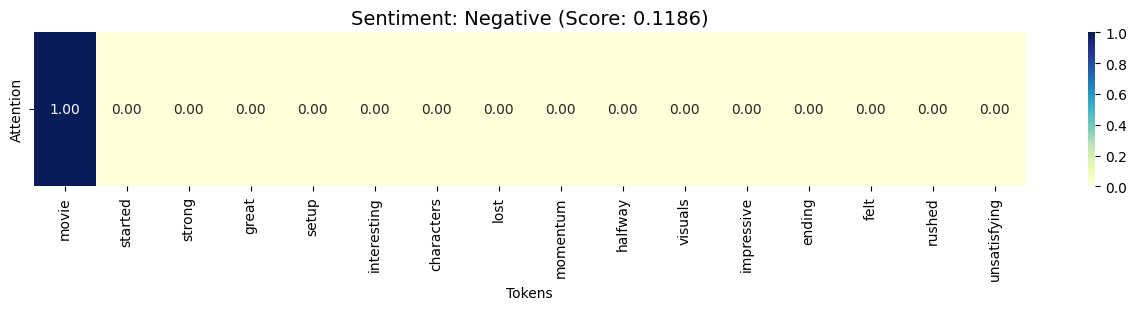


--- Training VanillaBidirectionalRNNWithLuongConcatAttention ---
Model : VanillaBidirectionalRNNWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9999)


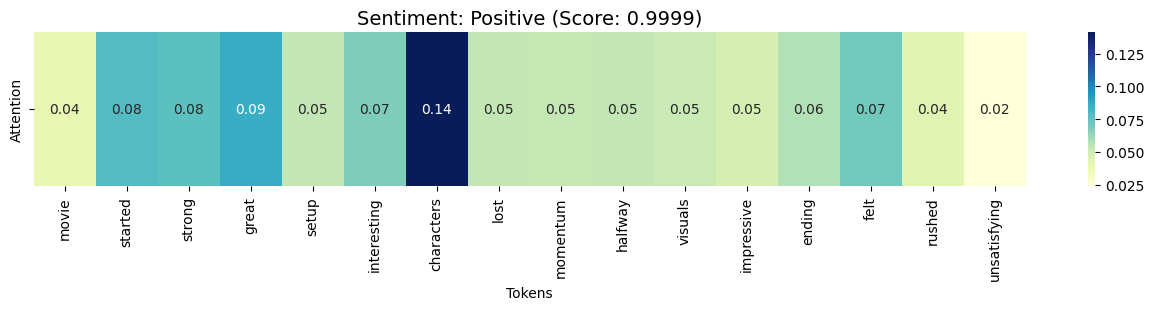


--- Training VanillaLSTMWithBahdanauAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.7669)


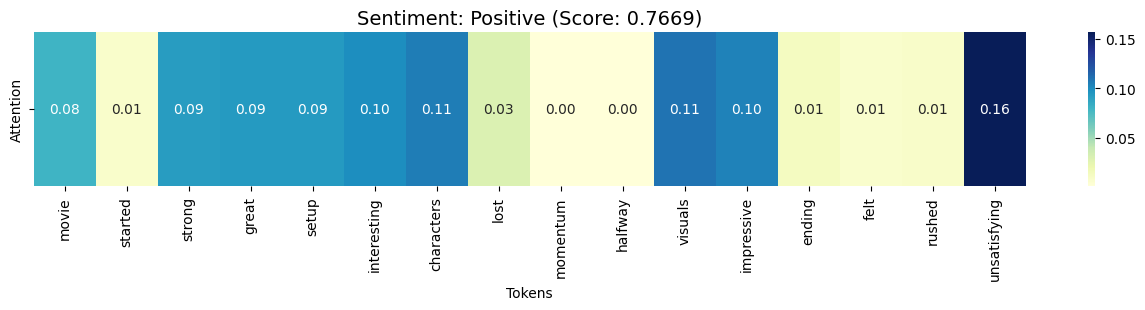


--- Training VanillaLSTMWithLuongDotProductAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.4853)


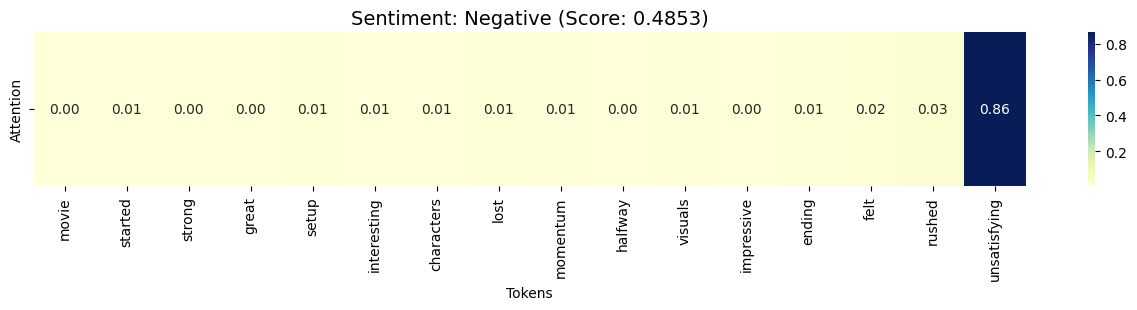


--- Training VanillaLSTMWithLuongGeneralAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.6584)


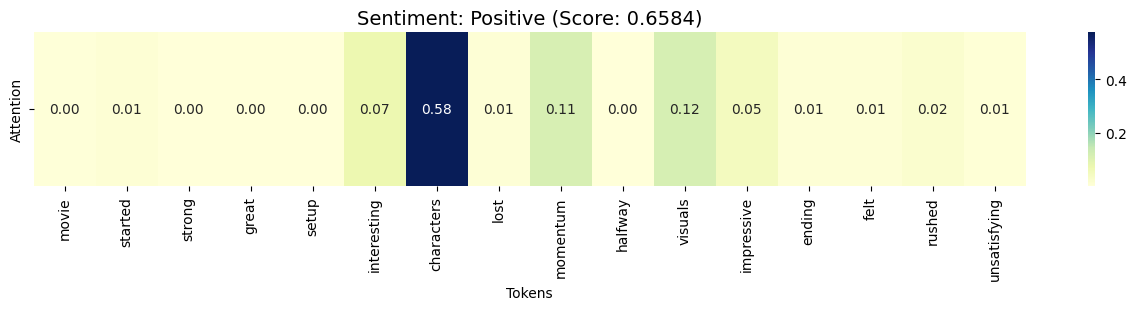


--- Training VanillaLSTMWithLuongConcatAttention ---
Model : VanillaLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.9116)


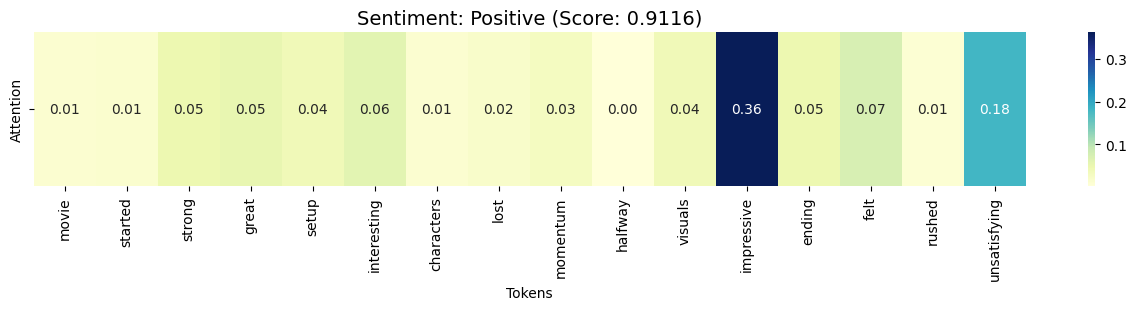


--- Training VanillaBidirectionalLSTMWithBahdanauAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.8916)


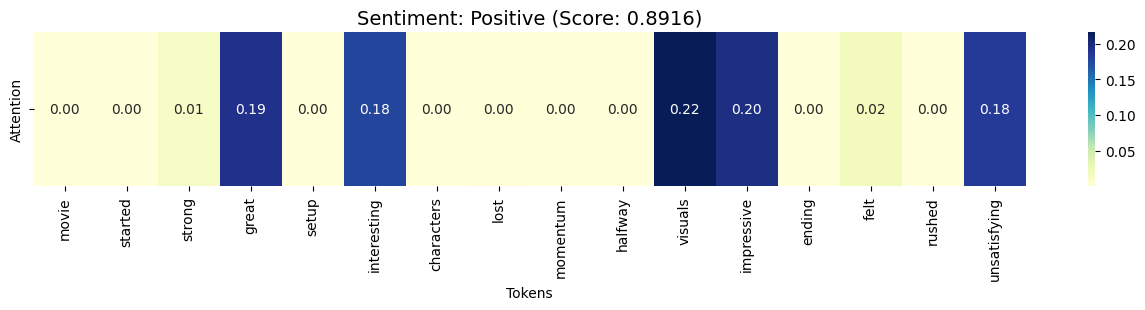


--- Training VanillaBidirectionalLSTMWithLuongDotProductAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.0625)


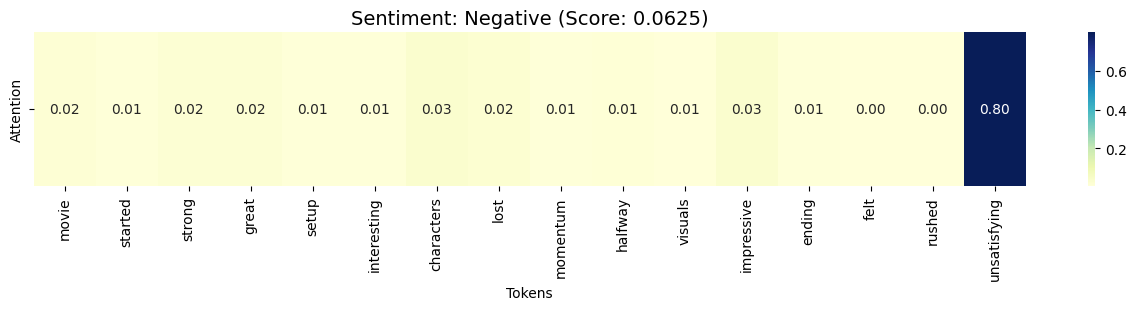


--- Training VanillaBidirectionalLSTMWithLuongGeneralAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Negative (Score: 0.3540)


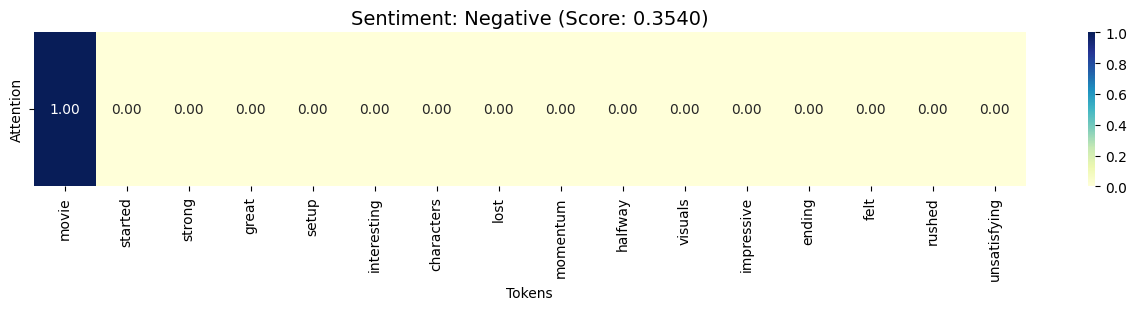


--- Training VanillaBidirectionalLSTMWithLuongConcatAttention ---
Model : VanillaBidirectionalLSTMWithPlugAndPlayAttention Sentiment: Positive (Score: 0.7149)


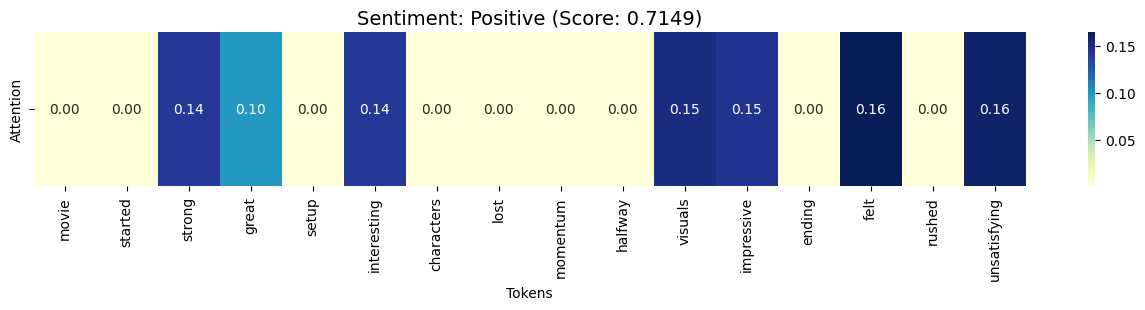

In [ ]:
### There must be some more ways to evaluate.. but how that I need to think !

sample_review = "The movie started off strong with a great setup and some interesting characters, but it lost momentum halfway through. While the visuals were impressive, the ending felt rushed and unsatisfying"

for pap_a_model in plug_and_play_attention_models:
    for attention_type, attention_kwarg in zip(attention_types, attention_kwargs):
        base_model_name = pap_a_model.__name__.replace("WithPlugAndPlayAttention", "")
        attn_name = attention_type.__name__.replace("Attention", "")
        full_model_name = f"{base_model_name}With{attn_name}Attention"
        
        print(f"\n--- Training {full_model_name} ---")

        model_path = f"./saved_models/{full_model_name}/best_model.pth"
        state_dict = torch.load(model_path)

        model = pap_a_model(
            embedding_matrix=embedding_matrix_tensor,
            attention_class=attention_type,
            attention_kwargs=attention_kwarg,
            hidden_dim=HIDDEN_DIM,
            freeze_embeddings=True
        ).to(device)


        fig = visualize_attention_for_review(sample_review,pap_a_model,attention_type,attention_kwarg,model_path)
        fig.savefig(f"./mixed/{full_model_name}.png")

